# 0. Import Libraries

In [ ]:
i

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# 1. Data Understanding (done)

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/RizqiSeijuuro/final-project-kelompok-03-aditya-bariq/main/Walmart.csv")
data.head()

Data Description:

Description:
One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to the inappropriate machine learning algorithm. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.

Deskripsi Kolom:
- Store - the store number
- Date - the week of sales
- Weekly_Sales - sales for the given store
- Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
- Temperature - Temperature on the day of sale
- Fuel_Price - Cost of fuel in the region
- CPI – Prevailing consumer price index
- Unemployment - Prevailing unemployment rate
- Holiday Events\
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [ ]:
data.info()

In [ ]:
# Dimensi dari dataset

print("Dataset ini berisi", data.shape[0],"baris dan", data.shape[1],"kolom. Dimana kolom Weekly_Sales sebagai kolom target")

Dari informasi di atas informasi yang didapat:
- Kolom "Date" harusnya bertipe data DateTime.
- Data hanya memiliki tipe data integer, float dan DateTime.

In [ ]:
 # Convert DD-MM-YYYY into YYYY-MM-DD format

data["Date"] = pd.to_datetime(data["Date"], format="%d-%m-%Y")
print("Kolom 'Date' sudah bertipe data", data["Date"].dtypes)

In [ ]:
data.describe()

In [ ]:
# Unique values for each feature
data.nunique().sort_values()

In [ ]:
data["Holiday_Flag"].unique()

In [ ]:
data["Store"].unique()

# 2. Exploratory Data Analysis (EDA)

## 2.1 Handling Missing Values (done)

In [ ]:
data.isnull().sum()



```
# This is formatted as code
```

## 2.2 Check Duplicated Data

Fitur yang seharusnya tidak memiliki nilai duplikat adalah "Store" dan "Date" karena tidak boleh ada 2 toko yang sama dan data yang berbeda untuk tanggal yang sama

In [ ]:
data[data[["Store", "Date"]].duplicated() == True]

In [ ]:
data[data.duplicated() == True]

## 2.3 Data Analysis

### 2.3.1 Feature Engineering: Date Variable

Sesuai deskripsi dataset, penjualan mingguan bergantung dengan tanggal karena biasanya pada libur besar penjualan cenderung akan meningkat. Sayangnya, fitur "Date" tidak dihitung korelasinya pada heatmap karena tipe datanya object, mari ubah fitur "Date" agar dapat diproses.

Sesuai guideline yang telah diberikan SME juga, fitur Date akan dipisah menjadi 4 kolom, yaitu: <br>
- Date (tanggal numerik) <br>
- Day (hari, i.e. Senin, Selasa, Rabu, dst) <br>
- Month (bulan) <br>
- Year (tahun) <br>


In [ ]:
# Copy original data into a new DataFrame because we"re going to manipulate it
original_data = data.copy(deep=True)

In [ ]:
# Extract information from Date into columns

data["Day"] = data["Date"].dt.day # Extract day of month
data["DayOfWeek"] = data["Date"].dt.weekday # Extract day of week
data["Month"] = data["Date"].dt.month # Extract month
data["Year"]  = data["Date"].dt.year # Extract year
data["WeekOfYear"] = data["Date"].dt.isocalendar().week # Extract week of year

data.head()

In [ ]:
data["DayOfWeek"].unique()

Setelah dikonversi menjadi hari, ternyata hanya terdapat 1 nilai, yaitu 4. Hal ini merupakan hal yang wajar karena hari pencataan penjualan mingguan memang dilakukan pada hari yang sama, yaitu hari Jumat. Sehingga kolom "DayOfWeek" akan kita buang karena hanya memiliki nilai tunggal, yang tentunya tidak akan mepengaruhi proses modelling.

Fitur "Date" dan "DateTime" juga akan di-drop karena informasinya sudah diekstrak menjadi fitur-fitur yang terpisah.

In [ ]:
# Drop DayofWeek, Date, and DateTime column
data.drop(["DayOfWeek", "Date"], axis = 1, inplace = True)

### 2.3.2 Data Distribution

In [ ]:
target = "Weekly_Sales"
features = [i for i in data.columns if i not in [target]] #store all features name
print(features)

In [ ]:
# Separate features into categorical and numerical

categorical_features = []
numerical_features = []
threshold = 100 # This is just an estimation, a categorial feature is likely to have less than 100 unique values

for feature in features:
    if data[feature].nunique() <= threshold:
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)

print("The Dataset has {} numerical & {} categorical features.".format(len(categorical_features),len(numerical_features)))
print("Numerical features are {}".format(numerical_features))
print("Categorical features are {}".format(categorical_features))

In [ ]:
# Change font size for ticks

def bigger_ticks_font_size(ax):
    ax.tick_params(axis = "x", labelsize = 13)
    ax.tick_params(axis = "y", labelsize = 13)

# Change font size for labels

def bigger_label_font_size(ax, xlabel_name, ylabel_name):
    ax.set_xlabel(xlabel_name, fontsize = 16)
    ax.set_ylabel(ylabel_name, fontsize = 16)

In [ ]:
# Extract hex codes for each color from Set2 color palette

pal = sns.color_palette("Set2")
print(pal.as_hex())

In [ ]:
# Create a new color palette consisted of the extracted hex codes from Set2 palette and other additional colors
palette = ["#fc8d62", "#ffd92f", "#e5c494", "#b3b3b3", "#66c2a5", "#96b9d0", "#8da0cb", "#ce94bc", "#eba7ac", "#f5ae52"]

#### 2.3.2.1 Data Distribution: Target

In [ ]:
#plotting label (Weekly Sales) data distribution

plt.figure(figsize=[10,4])
ax = sns.histplot(data["Weekly_Sales"], color ="#ffd92f", kde = True, bins = 30)

plt.title("Target Data Distribution", fontsize = 20)
bigger_ticks_font_size(ax)
bigger_label_font_size(ax, "Weekly Sales", "Count")

plt.show()

Bisa diblang persebaran data target kita tidak memiliki distribusi normal karena cenderung *skewed* ke kanan.

#### 2.3.2.2 Data Distribution: Numerical Features

In [ ]:
# Plotting outlier menggunakan boxplot

fig, ax = plt.subplots(ncols = 2, nrows = len(numerical_features), figsize=(12, 10))
for i in enumerate (numerical_features):
  sns.boxplot(x = data[i[1]], data = data, color = palette[i[0]], ax = ax[i[0]][0])
  sns.histplot(x = data[i[1]], color = palette[i[0]], kde = True, bins = 30, ax = ax[i[0]][1])

fig.suptitle("Data Distribution of Numerical Features", fontsize = 20, y=1.05)
sns.set_context(font_scale = 5)
plt.tight_layout(pad = 1.5)


Hampir semua kolom tersebut memiliki data yang hampir berdistribusi normal, kecuali kolom CPI.
- Kolom temperature bisa dibilang yang paling mendekati distribusi normal.
- Kolom Fuel_Price terpantau memiliki 2 puncak.
- Kolom Unemployment sedikit skewed ke kiri.

Terpantau kolom Temperature, dan Unemployment memiliki outliers. Hal ini akan kita tangani di tahapan berikutnya.

#### 2.3.2.3 Data Distribution: Categorical Features

In [ ]:
# Function to plot categorical features using countplot

def countplot_categorical_feature(col_name, title, palette, order = None):
    ax = sns.countplot(x = data[col_name], order = order, palette = palette)
    plt.suptitle("'{}' Feature Distribution".format(title), fontsize = 20)
    #plt.suptitle("Annual Sales during 2010-2012", fontsize = 20)
    bigger_ticks_font_size(ax)
    bigger_label_font_size(ax, title, "Count")


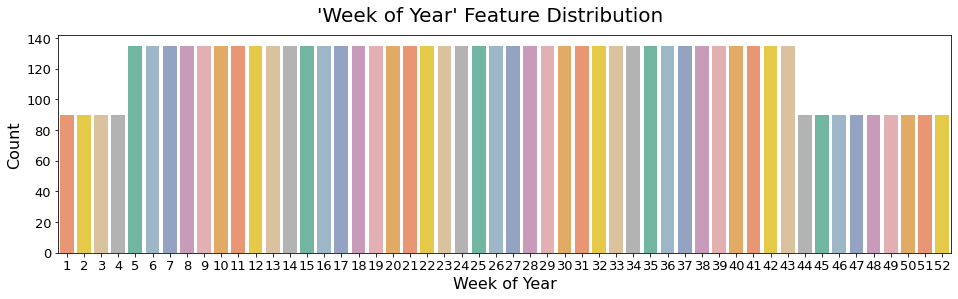

In [ ]:
# Plot "Week of Year" Feature
plt.figure(figsize=(16,4))
countplot_categorical_feature("WeekOfYear", "Week of Year", palette) #order by frequency

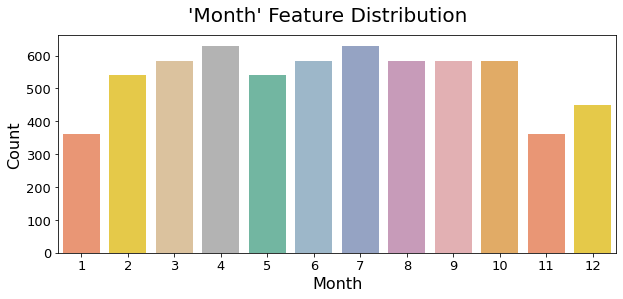

In [ ]:
plt.figure(figsize=(10,4))
countplot_categorical_feature("Month", "Month", palette)

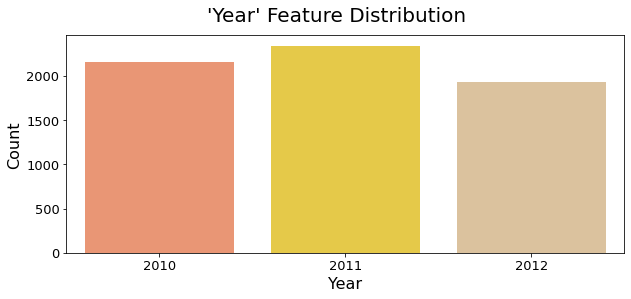

In [ ]:
plt.figure(figsize=(10,4))
countplot_categorical_feature("Year", "Year", palette)

Berdasarkan hari, pencatatan penjualan mingguan paling banyak dilakukan pada tanggal 2-6, 9-13, 16-20, 23-27, dan paling sedikit dilakukan pada tanggal 31, hal ini merupakan hal yang wajar karena tidak semua bulan jumlah harinya mencapai 31.

Berdasarkan minggu, pencatatan penjualan mingguan paling banyak dilakukan pada minggu ke-5 sampai 43, dan paling sedikit dilakukan pada minggu ke-1 sampai 4 (bulan Januari) dan minggu ke-44 sampai 52 (bulan November dan Desember).

Berdasarkan bulan, pencatatan penjualan mingguan paling banyak dilakukan pada bulan April dan Juli, yaitu lebih dari 600 pencatatan penjualan, dan paling sedikit bulan Januari dan bulan November, yaitu kurang dari 400 catatan penjualan.

Berdasarkan tahun, pencatatan penjualan mingguan paling banyak dilakukan pada tahun 2011, yaitu lebih dari 2000 pencatatan penjualan, sedangkan yang terendah adalah pada tahun 2012, yaitu kurang dari 2000 penjualan.

Ternyata pencatatan penjualan mingguan tidak dilakukan secara konsisten setiap minggunya. Apakah hal ini terjadi karena ada salah satu/beberapa *store* yang tidak melakukan pencatatan penjualan pada minggu tertentu? Mari kita lihat.

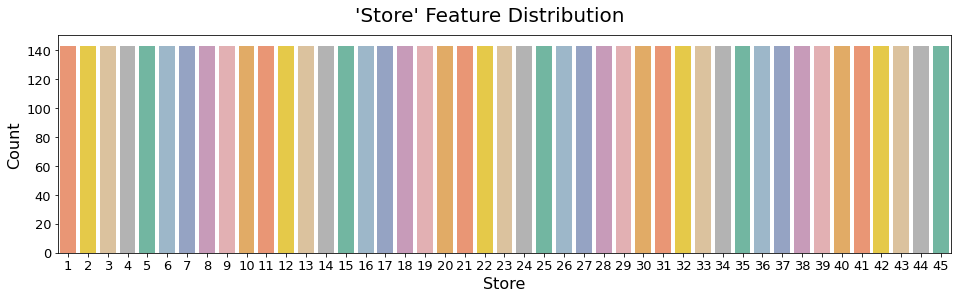

In [ ]:
plt.figure(figsize=(16,4))
countplot_categorical_feature("Store", "Store", palette)

Jumlah pencacatan penjualan per toko ternyata sama besarnya. Sehingga perbedaan pencatatan penjualan per bulan ataupun per tahun kemungkinan besar terjadi karena tidak adanya penjualan yang terjadi pada minggu tersebut.

In [ ]:
# Function to annotate frequency of each category in barplot

def annotate_barplot (ax, data):
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate("{:.1f}%".format(100.*y/data), (x.mean(), y),
            ha = "center", va = "bottom", fontsize = 12) # set the alignment of the text

In [ ]:
# Set double axes, count axis is on right, frequency on left

def set_double_axes(ax1, ax2, data, ax1_ax2_xlabel, ax1_ylabel, ax2_ylabel):
    ax2.yaxis.tick_left()
    ax1.yaxis.tick_right()

    # Also switch the labels over
    ax1.yaxis.set_label_position("right")
    ax2.yaxis.set_label_position("left")

    annotate_barplot (ax1, len(data)) #annotate barplot

    # Use a LinearLocator to ensure the correct number of ticks
    ax1.yaxis.set_major_locator(LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax1.set_ylim(0,len(data))

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(MultipleLocator(10))

    # Change font size for ticks and label
    bigger_ticks_font_size(ax1)
    bigger_ticks_font_size(ax2)
    bigger_label_font_size(ax1, ax1_ax2_xlabel, ax1_ylabel)
    bigger_label_font_size(ax2, ax1_ax2_xlabel, ax2_ylabel)

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  import sys


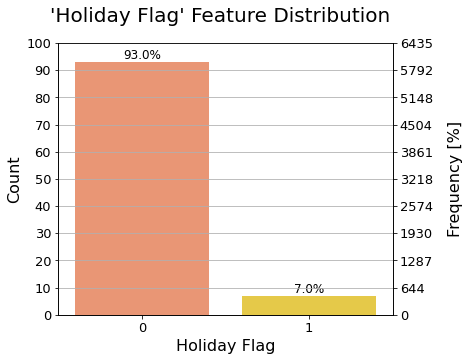

In [ ]:
# Count observation for "Holiday_Flag" columnn
plt.figure(figsize=(6, 5))
ax1 = sns.countplot(x = data["Holiday_Flag"], data = data, palette = palette)

ax2 = ax1.twinx() # Make twin axis
set_double_axes(ax1, ax2, data, "Holiday Flag", "Frequency [%]", "Count")
ax1.set_xticks([0,1],["No", "Yes"])
plt.suptitle("'Holiday Flag' Feature Distribution", fontsize = 20)

ax1.yaxis.labelpad = 15 # Increase label padding
plt.show()

Pada fitur "Holiday_Flag", sepertinya *value* 1 berarti pada minggu tersebut terdapat hari libur, dan sebaliknya *value* 0 berarti tidak terdapat hari libur pada minggu tersebut. Perbedaan jumlah minggu yang terdapat hari libur dan yang tidak memiliki perbandingan mendekat 1:13, hal ini merupakan hal yang wajar karena memang lebih banyak minggu yang berisi hari biasa dibandingkan minggu yang terdapat hari liburnya.

### 2.3.3 Feature Analysis

#### 2.3.3.1 Feature Analysis: Holiday_Flag vs Weekly_Sales

In [ ]:
# Function to plot barplot with frequency annotation
def barplot_with_annotation (x, y, x_name, y_name, data, palette, ax, title_bool = False):
    ax.set_title("{} vs {}".format(x_name, y_name), fontsize = 20, pad = 15)
    ax.title.set_visible(title_bool) #to turn on and off the title
    sns.barplot(x = x, y = y, data =  data, palette = palette, ax = ax)
    annotate_barplot(ax, data[y].sum())
    bigger_ticks_font_size(ax)
    bigger_label_font_size(ax, x_name, y_name)


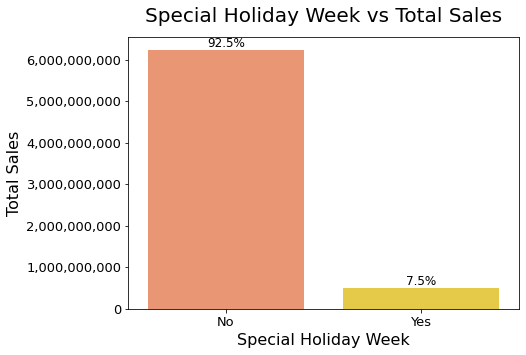

In [ ]:
# Plot total on holiday/non-holiday week
fig, ax = plt.subplots(figsize = (7, 5))
Holiday_list = ['No','Yes']
total_sales = data.groupby("Holiday_Flag")["Weekly_Sales"].agg("sum").reset_index() #group the sum of weekly sales by holiday
barplot_with_annotation("Holiday_Flag", "Weekly_Sales", "Special Holiday Week", "Total Sales", total_sales, palette, ax, True)
ax.set_xticklabels(Holiday_list)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()

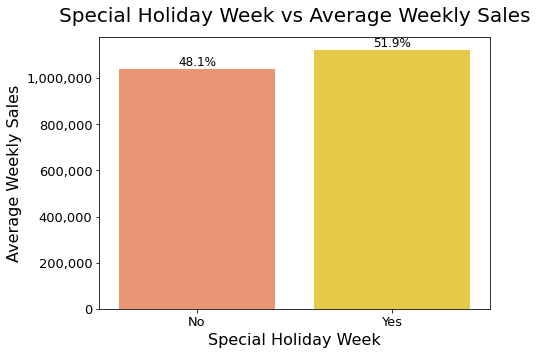

In [ ]:
# Plot average sales on holiday/non-holiday week
fig, ax = plt.subplots(figsize = (7,5))

avg_sales = data.groupby("Holiday_Flag")["Weekly_Sales"].agg("mean").reset_index() #group the mean of weekly sales by holiday
barplot_with_annotation("Holiday_Flag", "Weekly_Sales", "Special Holiday Week", "Average Weekly Sales", avg_sales, palette, ax, True)
ax.set_xticklabels(Holiday_list)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

**Total penjualan** pada minggu yang terdapat hari libur besar hanya mencapai 7.5% dan untuk minggu tanpa hari libur besar mencapai 92.5%. Hal ini merupakan yang wajar karena dalam 1 tahun terdapat lebih banyak hari non-libur dibandingkan hari libur (berdasarkan plot sebelumnya sebesar 13:1), sehingga total penjualan tentunya akan banyak pada minggu tanpa libur.

Namun, minggu dengan hari libur besar memiliki **rata-rata penjualan** yang sedikit lebih besar dibandingkan minggu tanpa hari libur besar, selisihnya mencapai 3.2%.

In [ ]:
data_holiday = data[data["Holiday_Flag"] == True]
data_holiday

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,WeekOfYear
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,6
31,1,1507460.69,1,78.69,2.565,211.495190,7.787,10,9,2010,36
42,1,1955624.11,1,64.52,2.735,211.748433,7.838,26,11,2010,47
47,1,1367320.01,1,48.43,2.943,211.404932,7.838,31,12,2010,52
53,1,1649614.93,1,36.39,3.022,212.936705,7.742,11,2,2011,6
...,...,...,...,...,...,...,...,...,...,...,...
6375,45,746129.56,1,71.48,3.738,186.673738,8.625,9,9,2011,36
6386,45,1170672.94,1,48.71,3.492,188.350400,8.523,25,11,2011,47
6391,45,869403.63,1,37.79,3.389,189.062016,8.523,30,12,2011,52
6397,45,803657.12,1,37.00,3.640,189.707605,8.424,10,2,2012,6


Terdapat 450 baris data yang terjadi pada hari libur besar, mari kita cek pada minggu keberapa hari libur besar itu terjadi

In [ ]:
data_holiday["WeekOfYear"].unique()

<IntegerArray>
[6, 36, 47, 52]
Length: 4, dtype: UInt32

In [ ]:
# Group dataset by Store, WeekOfYear, and Year for better understanding
data_holiday_grouped = data_holiday.groupby(["Store", "WeekOfYear", "Year"]).sum()
data_holiday_grouped.shape

(450, 8)

In [ ]:
data_holiday_grouped.loc[1] #print data for Store 1

Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
WeekOfYear Year                                                        
6          2010    1641957.44             1        38.51       2.548   
           2011    1649614.93             1        36.39       3.022   
           2012    1802477.43             1        48.02       3.409   
36         2010    1507460.69             1        78.69       2.565   
           2011    1540471.24             1        76.00       3.546   
           2012    1661767.33             1        83.96       3.730   
47         2010    1955624.11             1        64.52       2.735   
           2011    2033320.66             1        60.14       3.236   
52         2010    1367320.01             1        48.43       2.943   
           2011    1497462.72             1        44.55       3.129   

                        CPI  Unemployment  Day  Month  
WeekOfYear Year                                        
6          2010  211.242170         8.106   12      2  
           2011  212.936705         7.742   11      2  
           2012  220.265178         7.348   10      2  
36         2010  211.495190         7.787   10      9  
           2011  215.861056         7.962    9      9  
           2012  222.439015         6.908    7      9  
47         2010  211.748433         7.838   26     11  
           2011  218.467621         7.866   25     11  
52         2010  211.404932         7.838   31     12  
           2011  219.535990         7.866   30     12

Sesuai deskripsi pada dataset, terdapat 4 hari libur besar pada dataset:

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 <br>
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 <br>
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 <br>
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 <br>

Berdasarkan data yang telah dilaukan grouping (data_holiday_grouped), terdapat beberapa *insight* mengenai data:
- Tahun 2013 tidak ada pada dalam dataset sehingga dapat diabaikan.
- Super Bowl: seluruhnya terdapat dalam dataset
- Labor Day: seluruhnya terdapat dalam dataset
- Thanksgiving: tidak ada data tahun 2012
- Christmas:  tidak ada data tahun 2012

Alasan mengapa untuk libur Thanksgiving dan Christmas tidak terdapat data tahun 2012, karena Range Data hanya dari 5 Februari 2010 - 6 Oktober 2012. Sedangkan Thanksgiving dan Christmas yang tidak ada masing-masing berada di tanggal 23-Nov-12 dan 28-Dec-12

In [ ]:
data[(data["Year"] == 2012) & ((data["Month"] == 11) | (data["Month"] == 12))]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,WeekOfYear


Dapat dipastikan tidak terdapat data penjualan pada bulan 11 dan 12 pada tahun 2012.

Sekarang, mari kita kelompokkan data berdasarkan tipe libur spesifiknya

In [ ]:
# Create new columns based on A WEEK OF each specific holiday

data["Super_Bowl"]   = np.where(data["WeekOfYear"] == 6, 1, 0) # Value will be 1 if the condition is right and vice versa
data["Labor_Day"]    = np.where(data["WeekOfYear"] == 36, 1, 0)
data["Thanksgiving"] = np.where(data["WeekOfYear"] == 47, 1, 0)
data["Christmas"]    = np.where(data["WeekOfYear"] == 52, 1, 0)

In [ ]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,WeekOfYear,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,5,0,0,0,0
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,6,1,0,0,0
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,7,0,0,0,0
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010,8,0,0,0,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,5,3,2010,9,0,0,0,0


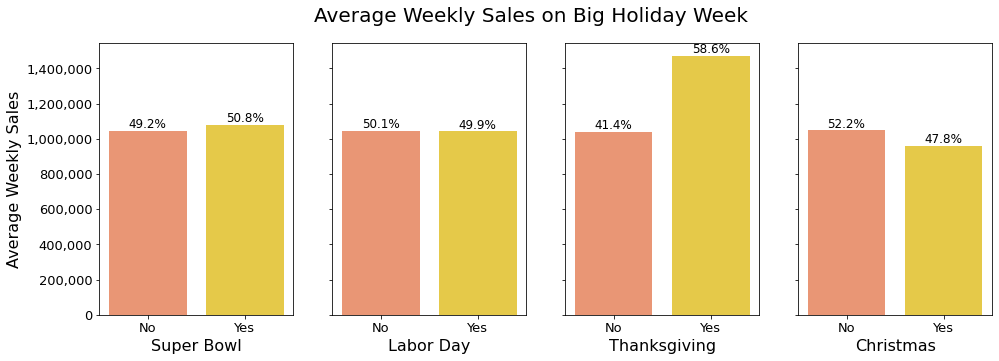

In [ ]:
fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize=(16, 5), sharey = "row")

holiday_cols_name = ["Super_Bowl", "Labor_Day", "Thanksgiving", "Christmas"]
holiday_name = ["Super Bowl", "Labor Day", "Thanksgiving", "Christmas"]

for i in enumerate (holiday_cols_name):
    data_temp = data.groupby(i[1])["Weekly_Sales"].agg("mean").reset_index() #group the sum of weekly sales by holiday
    barplot_with_annotation(i[1], "Weekly_Sales", holiday_name[i[0]], "Average Weekly Sales", data_temp, palette, ax[i[0]])
    if(i[0]>0): ax[i[0]].set(ylabel = None) #to set yaxis ticks off for the second, third, fourth plot
    ax[i[0]].set_xticklabels(Holiday_list) #change ticks from 0-1 into yes-no

fig.suptitle("Average Weekly Sales on Big Holiday Week", fontsize = 20)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [ ]:
# Create new columns based on A WEEK BEFORE each specific holiday

data["Before_Super_Bowl"]   = np.where(data["WeekOfYear"] == 5, 1, 0)
data["Before_Labor_Day"]    = np.where(data["WeekOfYear"] == 35, 1, 0)
data["Before_Thanksgiving"] = np.where(data["WeekOfYear"] == 46, 1, 0)
data["Before_Christmas"]    = np.where(data["WeekOfYear"] == 51, 1, 0)

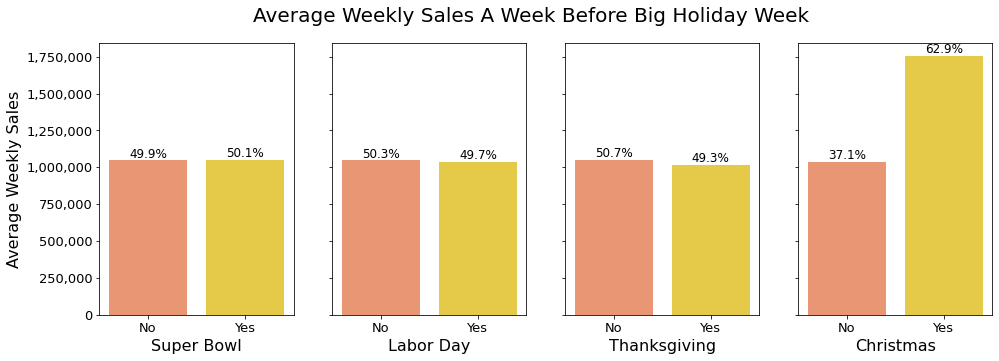

In [ ]:
fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize=(16, 5), sharey = "row")

before_holiday_cols_name = ["Before_Super_Bowl", "Before_Labor_Day", "Before_Thanksgiving", "Before_Christmas"]
holiday_name = ["Super Bowl", "Labor Day", "Thanksgiving", "Christmas"]

for i in enumerate (before_holiday_cols_name):
    data_temp = data.groupby(i[1])["Weekly_Sales"].agg("mean").reset_index() #group the sum of weekly sales by holiday
    barplot_with_annotation(i[1], "Weekly_Sales", holiday_name[i[0]], "Average Weekly Sales", data_temp, palette, ax[i[0]])
    if(i[0]>0): ax[i[0]].set(ylabel = None) #to set yaxis ticks off for the second, third, fourth plot
    ax[i[0]].set_xticklabels(Holiday_list) #change ticks from 0-1 into yes-no

fig.suptitle("Average Weekly Sales A Week Before Big Holiday Week", fontsize = 20)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Pada minggu libur **Super Bowl** dan **Labor Day**, ternyata penjualannya tidak jauh berbeda dengan minggu tanpa hari libur. Sementara untuk minggu yang terdapat libur **Thanksgiving**, penjualannya lebih banyak dibandingkan minggu tanpa hari libur, dengan selisih mencapai 16.2%. Sementara untuk minggu yang terdapat libur **Christmas**, penjualannya ternyata lebih sedikit dibandingkan minggu tanpa hari libur dengan selisih mencapai 3.8%, tetapi penjualannya lebih banyak pada satu minggu sebelum libur **Christmas** dengan selisih mencapai 25.8%.

Hal ini masuk akal karena tepat pada minggu **Thanksgiving**, toko-toko di US sering mengadakan diskon Black Friday dan terkadang diikuti dengan diskon Cyber Monday. Lalu, sepertinya orang lebih sering membeli hadiah natal sebelum libur **Christmas** sehingga penjualan pada minggu natal sendiri tidak meningkat.

#### 2.3.3.1 Feature Analysis: Day, Month, Year vs Weekly_Sales

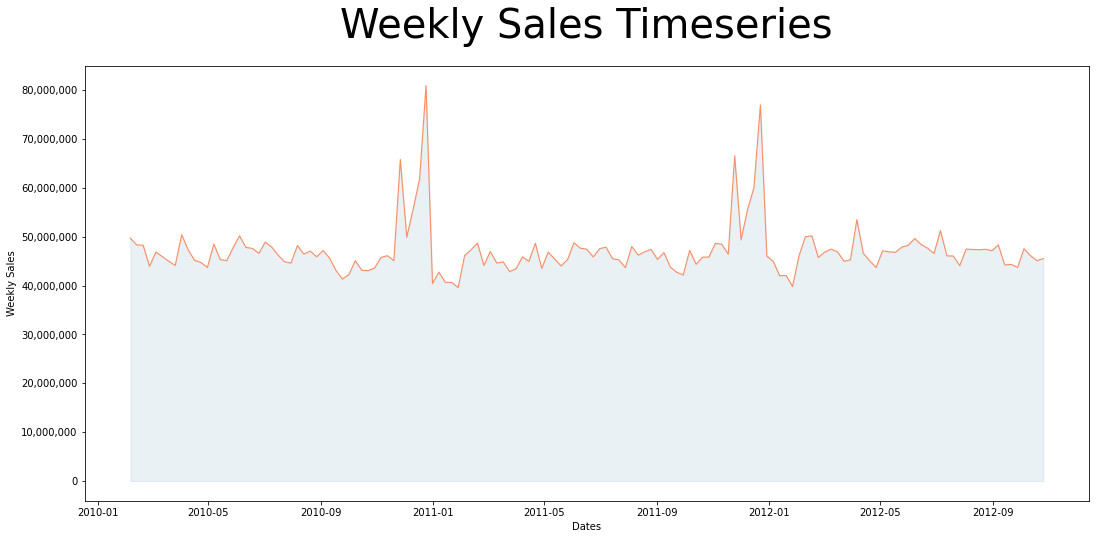

In [ ]:
temp_data = original_data.groupby(['Date']).sum()
fig, ax = plt.subplots(figsize=(18, 8))

plt.title("Weekly Sales Timeseries", fontsize=40, y=1.05)
plt.xlabel('Dates')
plt.ylabel('Weekly Sales')
#list(data['month_year'].astype(str))
ax.fill_between(temp_data.index, temp_data['Weekly_Sales'], color=palette[5], linewidth=1.1, alpha=0.2)
ax.plot(temp_data.index, temp_data['Weekly_Sales'], color=palette[0], linewidth=1.1)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Dapat dipastikan penjualan terbesar terjadi di sekitar bulan November hingga Desember. Ini menguatkan asumsi bahwa memang Bulan November hingga Desember ini merupakan demand barangnya tertinggi

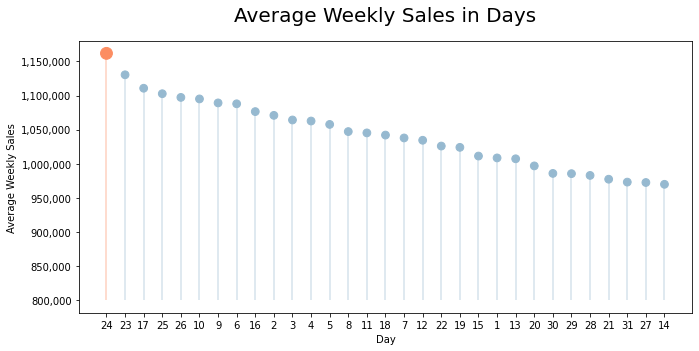

In [ ]:
# Reorder it based on values:
temp_data = data.groupby('Day').mean().sort_values(by='Weekly_Sales', ascending=False)
temp_data['Day'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

# Create a color if the Sales is Max
my_color=np.where(temp_data['Weekly_Sales']==temp_data['Weekly_Sales'].max(), palette[0], palette[5])
my_size=np.where(temp_data['Weekly_Sales']==temp_data['Weekly_Sales'].max(), 140, 60)

# The horizontal plot is made using the vline() function
plt.figure(figsize=(11,5))
plt.vlines(x=temp_data['Day'], ymin=800000, ymax=temp_data['Weekly_Sales'], color=my_color, alpha=0.4)
plt.scatter(temp_data['Day'], temp_data['Weekly_Sales'], color=my_color, s=my_size, alpha=1)

# Add title and axis names
plt.title("Average Weekly Sales in Days", fontsize=20, y=1.05)
plt.xlabel('Day')
plt.ylabel('Average Weekly Sales')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
# show the graph
plt.show()

Penjualan terbesar terjadi di tanggal 24. Namun, perlu diperhatikan bahwa grafik tersebut kurang representatif dalam menjelaskan penjualan harian karena setiap data diambil setiap hari Jum'at. Artinya dalam 1 minggu hanya diambil data 1 kali

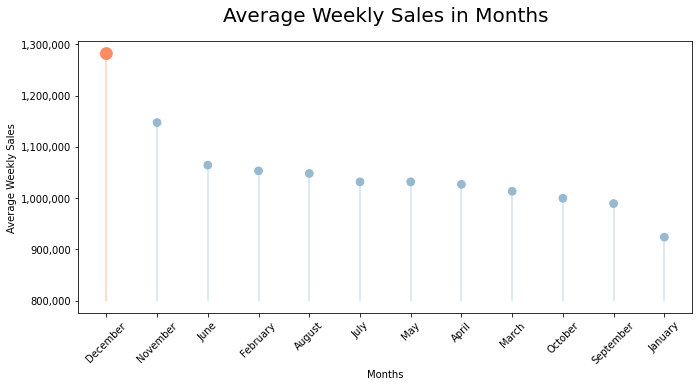

In [ ]:
# Reorder it based on values:
temp_data = data.groupby('Month').mean().sort_values(by='Weekly_Sales', ascending=False)
temp_data['Month'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

# Create a color if the Sales is Max
my_color=np.where(temp_data['Weekly_Sales']==temp_data['Weekly_Sales'].max(), palette[0], palette[5])
my_size=np.where(temp_data['Weekly_Sales']==temp_data['Weekly_Sales'].max(), 140, 60)

# The horizontal plot is made using the vline() function
fig, ax = plt.subplots(figsize=(11,5))
plt.vlines(x=temp_data['Month'], ymin=800000, ymax=temp_data['Weekly_Sales'], color=my_color, alpha=0.4)
plt.scatter(temp_data['Month'], temp_data['Weekly_Sales'], color=my_color, s=my_size, alpha=1)

# Add title and axis names
plt.title("Average Weekly Sales in Months", fontsize=20, y=1.05)
plt.xlabel('Months')
plt.ylabel('Average Weekly Sales')
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
month_name = original_data[original_data['Date'].dt.year == 2011]['Date'].dt.month_name().unique().astype(str)
for i in range(len(labels)):
  month = int(labels[i])
  labels[i] = str(month_name[month-1])
ax.set_xticklabels(labels, rotation=45)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
# show the graph
plt.show()

Rerata penjualan mingguan terbesar dalam waktu bulanan terjadi pada bulan Desember dan diikuti bulan November. Tentunya, hal tersebut dikarenakan terdapat Thanksgiving dan Christmas

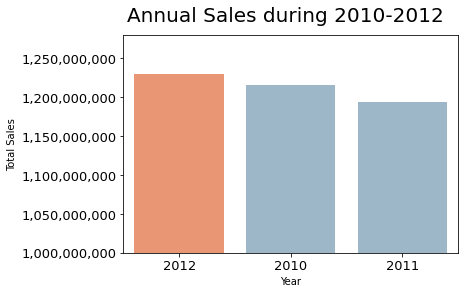

In [ ]:
temp_data = data[(data['Month'] >= 2) & (data['Month'] <= 7)].groupby('Year').sum().sort_values(by='Weekly_Sales', ascending=False)
temp_data['Year'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

ax = sns.barplot(x = temp_data['Year'], y= temp_data["Weekly_Sales"], palette = [palette[0],palette[5],palette[5]])
#plt.suptitle("'{}' Feature Distribution".format(title), fontsize = 20)
ax.set(ylim=(1000000000, temp_data['Weekly_Sales'].max()+50000000))
plt.suptitle("Annual Sales during 2010-2012", fontsize = 20)
bigger_ticks_font_size(ax)
plt.ylabel('Total Sales')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Perlu diperhatikan bahwa range data hanya berada di antara 5 Februari 2010 - 6 Oktober 2012. Artinya data setiap tahunnya tidak seimbang. Jadi, Total Weekly Sales dihitung dari bulan Februari hingga Juli saja untuk melihat perbandingannya.

Ternyata, penjualan terbesar berada di tahun 2012.

#### 2.3.3.2 Feature Analysis: Unempoloyment, CPI vs Weekly_Sales

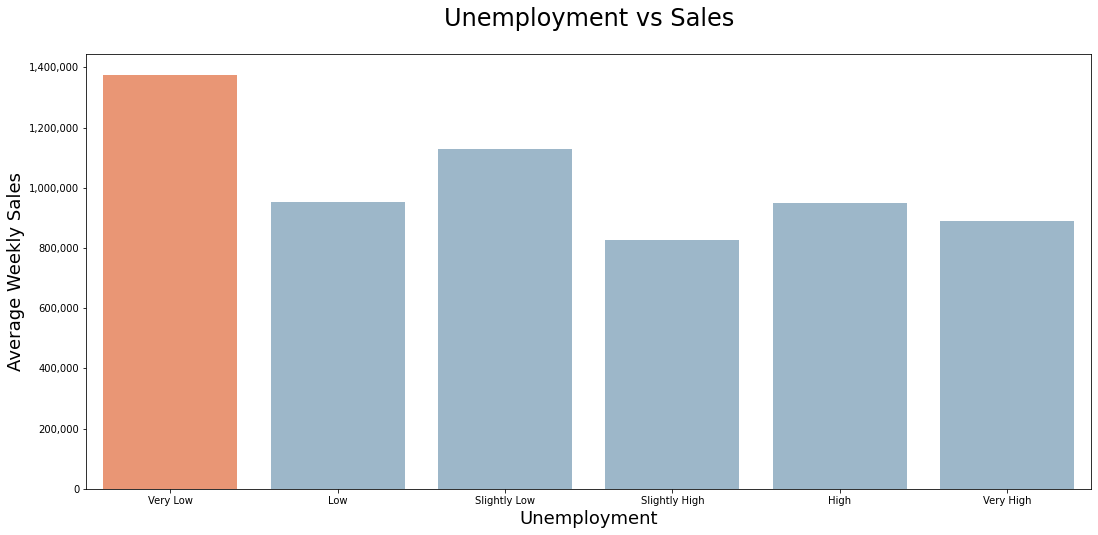

In [ ]:
# No 5 mengklasifikasikan kelas dari Unemployment dan membuat kolom baru bernama Unemployment_class
def unem_classification(unem):
    if unem >= 13:
        return 6
    elif unem >= 11:
        return 5
    elif unem >= 9:
        return 4
    elif unem >= 7:
        return 3
    elif unem >= 5:
        return 2
    elif unem < 5:
        return 1
    else:
        return np.nan

# Menerapkan fungsi unem_classification ke dataframe
data["Unemployment_class"] = data.apply(lambda x: unem_classification(x.Unemployment), axis=1)

temp_data = data.groupby("Unemployment_class").mean()
temp_data['Unemployment_class'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18,8))

my_color=np.where(temp_data['Weekly_Sales']==temp_data['Weekly_Sales'].max(), palette[0], palette[5])
sns.barplot(x = temp_data['Unemployment_class'], y= temp_data["Weekly_Sales"], palette = my_color)
plt.title("Unemployment vs Sales", fontsize=24, y=1.05)
plt.xlabel('Unemployment', fontsize=18)
plt.ylabel('Average Weekly Sales', fontsize=18)
fig.canvas.draw()
unemClass = ['Very Low','Low','Slightly Low','Slightly High','High','Very High']
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
  unemp = int(labels[i])
  labels[i] = str(unemClass[unemp-1])
ax.set_xticklabels(labels)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

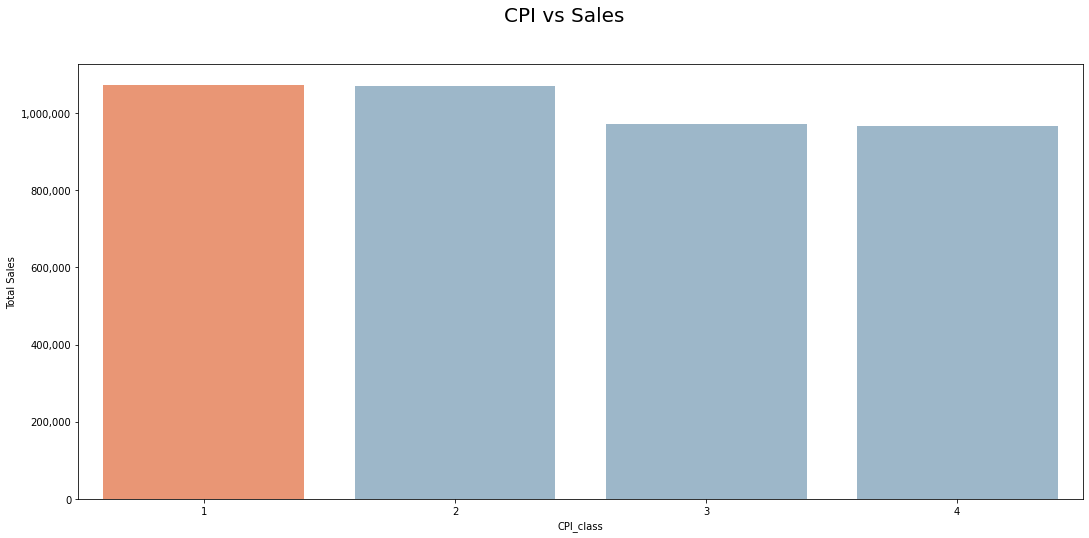

In [ ]:
# No 5 mengklasifikasikan kelas dari CPI dan membuat kolom baru bernama CPI_class
def CPI_classification(unem):
    if unem >= 214:
        return 4
    elif unem >= 213:
        return 3
    elif unem >= 212:
        return 2
    elif unem < 212:
        return 1
    else:
        return np.nan

# Menerapkan fungsi CPI_classification ke dataframe
data["CPI_class"] = data.apply(lambda x: CPI_classification(x.CPI), axis=1)

temp_data = data.groupby("CPI_class").mean()
temp_data['CPI_class'] = temp_data.index.astype(str)
temp_data = temp_data.reset_index(drop=True)
zenius = ['#A338EB', '#FFC007']

fig = plt.subplots(figsize=(18,8))
my_color=np.where(temp_data['Weekly_Sales']==temp_data['Weekly_Sales'].max(), palette[0], palette[5])
sns.barplot(x = temp_data['CPI_class'], y= temp_data["Weekly_Sales"], palette = my_color)
plt.suptitle("CPI vs Sales", fontsize = 20)
plt.ylabel('Total Sales')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Dari Grafik Unemployment vs Sales dan CPI vs Sales, tampaknya faktor ekonomi tidak terlalu banyak dalam mempengaruhi Weekly Sales dibandingkan Hari Libur Besar.

#### 2.3.3.4 Feature Analysis: Monthly Sales vs Store Number

In [ ]:
data_temp = data.copy(deep = True)

# Create a new column for "Year-Month" format
data_temp["Month_Year"] = original_data["Date"].dt.to_period("M")
data_temp["Month_Year"].unique()

<PeriodArray>
['2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08',
 '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03',
 '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10',
 '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
 '2012-06', '2012-07', '2012-08', '2012-09', '2012-10']
Length: 33, dtype: period[M]

In [ ]:
import plotly.express as px

# Create a new column to store "Month_Year"
data_temp["Month_Year"] = data_temp["Month_Year"].astype(str)

# Group Total Weekly_Sales by Store and Month_Year
sales = data_temp.groupby(["Store","Month_Year"])["Weekly_Sales"].sum().reset_index()

# Plot animation bar chart
fig = px.bar(sales, x = "Weekly_Sales", y = "Store",
             orientation = "h", height=700, title=" TOTAL MONTHLY SALES BY STORE NUMBER",
            animation_frame = "Month_Year", animation_group = "Store", range_x = [0,15000000], template = "seaborn", color = "Store", )
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000

# Change bar color
fig.update_traces(marker_color = palette[:5]*9)
#Change bar color throghout all frames
for f in fig.frames:
    f.data[0].update(marker_color = palette[:5]*9)
fig.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## 2.4 Finding and Handling Outliers

In [ ]:
def finding_outlier(data, column):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR  = Q3-Q1
  lower_bound = (Q1-(1.5*IQR))
  upper_bound = (Q3+(1.5*IQR))
  outlier = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

  return outlier

In [ ]:
finding_outlier(data, "Temperature")

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,...,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class
910,7,558027.77,0,-2.06,3.011,191.762589,8.818,4,2,2011,...,0,0,0,0,1,0,0,0,3,1
2336,17,1083071.14,0,6.23,2.891,127.191774,6.866,7,1,2011,...,0,0,0,0,0,0,0,0,2,1
3626,26,817485.14,0,5.54,3.243,133.105968,7.907,28,1,2011,...,0,0,0,0,0,0,0,0,3,1


Nilai pencilan untuk fitur "Temperature" sepertinya masih bisa dibilang wajar karena hanya terdapat 3 data, lalu nilainya sangat rendah dan itu sangat mungkin terjadi di musim dingin. Musim dingin di US biasanya berlangsung dari Desember, Januari, dan Februari yang mana sesuai dengan data *outlier* di atas. Oleh karena itu, outlier ini akan kita biarkan saja.

In [ ]:
finding_outlier(data, "Unemployment").shape

(481, 21)

Nilai pencilan pada fitur "Unemployment" terdiri dari 481 baris, lumayan banyak. Berdasarkan boxplot di blok kode sebelumnya, nilai pencilan terdapat di kuartil bawah maupun kuartil atas. Mari kita kelompokkan datanya berdasarkan kuartil untuk melihat apakah tingkat *unemployment* yang rendah memiliki ciri-ciri tertentu dan begitu juga sebaliknya.

In [ ]:
Q1 = data["Unemployment"].quantile(0.25)
Q3 = data["Unemployment"].quantile(0.75)
IQR  = Q3-Q1
outlier_lower_bound = data[(data["Unemployment"] < (Q1-(1.5*IQR)))]
outlier_upper_bound = data[(data["Unemployment"] > (Q3+(1.5*IQR)))]

In [ ]:
print(outlier_lower_bound["Year"].unique(), outlier_upper_bound["Year"].unique())

[2012] [2010 2011 2012]


Ternyata tingkat unemployment rendah (yang berada di lower bound) terjadi pada tahun 2012, sedangkan yang tinggi (berada di upper bound) terjadi pada seluruh tahun. Kita tidak memiliki data yang cukup untuk *handling* outlier ini sehingga akan ada 3 skenario yang dipakai, yaitu (1) *outlier* dibiarkan (2) outlier dihapus (3) transformasi outlier  

In [ ]:
data_dropped_outlier = data.drop(outlier_lower_bound.index)
data_dropped_outlier = data.drop(outlier_upper_bound.index)

In [ ]:
# Flooring and capping outliers
data_tf_outlier = data.copy()

percentiles = data["Unemployment"].quantile([0.1, 0.9]).values
data_tf_outlier["Unemployment"] = np.clip(data["Unemployment"], percentiles[0], percentiles[1])
# Values smaller than percentiles[0] (10% percentile) will become percentiles[0]
# Values bigger than percentiles[1] (90% percentile) will become percentiles[1]

print("Low percentile: ", percentiles[0])
print("High percentile: ", percentiles[1])
print("")

print("Sisa outliers fitur Unemployment pada Dataset 1 (outlier dibiarkan):", len(finding_outlier(data,"Unemployment")))
print("Sisa outliers fitur Unemployment pada Dataset 2 (seluruh outlier di-drop):", len(finding_outlier(data_dropped_outlier,"Unemployment")))
print("Sisa outliers fitur Unemployment pada Dataset 3 (flooring dan capping outlier):", len(finding_outlier(data_tf_outlier,"Unemployment")))

Low percentile:  6.061
High percentile:  9.863

Sisa outliers fitur Unemployment pada Dataset 1 (outlier dibiarkan): 481
Sisa outliers fitur Unemployment pada Dataset 2 (seluruh outlier di-drop): 181
Sisa outliers fitur Unemployment pada Dataset 3 (flooring dan capping outlier): 0


Pada dataset ke-2, masih terdapat sisa outlier setelah sebelumnya seluruh outlier di-drop. Hal ini terjadi karena setelah outlier di-drop, distribusi datanya berubah sehingga nilai yang tadinya bukan outlier (berada di atas kuartil bawah dan di bawah kuartil atas) akan menjadi data dengan nilai paling ujung sehingga terdeteksi menjadi outlier.

In [ ]:
data_dropped_outlier

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,...,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,...,0,0,0,0,1,0,0,0,3,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,...,1,0,0,0,0,0,0,0,3,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,...,0,0,0,0,0,0,0,0,3,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010,...,0,0,0,0,0,0,0,0,3,1
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,5,3,2010,...,0,0,0,0,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,28,9,2012,...,0,0,0,0,0,0,0,0,3,1
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,5,10,2012,...,0,0,0,0,0,0,0,0,3,1
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,12,10,2012,...,0,0,0,0,0,0,0,0,3,1
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,19,10,2012,...,0,0,0,0,0,0,0,0,3,1


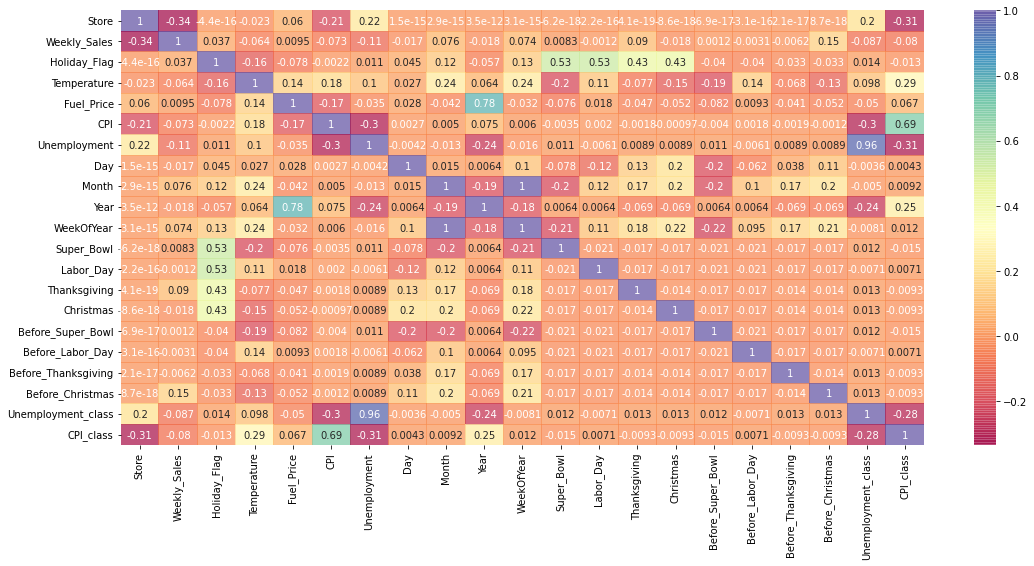

In [ ]:
plt.figure(figsize=(18, 8))
sns.heatmap(data = data.corr(), cmap = "Spectral", annot = True, alpha = 0.7)

## 2.5 Data Encoding

Data kategorikal perlu di-encode agar model dapat melakukan prediksi dengan lebih baik. Fitur "Store" sebenarnya sudah menjadi data numerik dan dapat diproses oleh model, nilainya terdiri dari 1-45. Tetapi, model kita akan mengira ada hierarki atau urutan dari fitur tersebut, seperti 1 < 2 < 3 ... < 45, padahal fitur "Store" tidak memiliki hierarki seperti itu (Store 1 tidak kurang dari/tingkatannya lebih rendah dari Store 2 dan begitu juga sebaliknya). Sehingga kita perlu memisahkan kolom "Store" menjadi beberapa kolom yang bernilai 1 dan 0.

Untuk data kategorikal yang bersifat *binary* seperti Holiday_Flag, kita tidak memerlukan encoding data lagi karena nanti akan bersifat redundan (sumber: [stackoverflow](https://stackoverflow.com/questions/43515877/should-binary-features-be-one-hot-encoded)). Jadi, tidak seluruh data kategorikal akan di-encode, fitur yang akan kita lakukan encoding adalah Store, Day, Month, Year, dan WeekOfYear. Kita akan menggunakan Dummy Encoding di sini karena lebih jumlah variabel yang akan dihasilkan lebih sedikit dibandingkan One-Hot Encoding (sumber: [Toward Data Science](https://towardsdatascience.com/encoding-categorical-variables-one-hot-vs-dummy-encoding-6d5b9c46e2db#:~:text=Both%20expand%20the%20feature%20space,category%20in%20each%20categorical%20variable.))

In [ ]:
# Store all column names that we want to encode
cols_to_encode = ["Store", "Day", "Month", "Year", "WeekOfYear"]

# Create a copy of each dataframe
data_enc = data.copy(deep = True)
data_drop_outlier_enc = data_dropped_outlier.copy(deep = True)
data_tf_outlier_enc = data_tf_outlier.copy(deep = True)

# Dummy encoding
for i in cols_to_encode:
    # Data with outliers
    data_enc = pd.concat([data_enc.drop([i], axis=1), pd.DataFrame(pd.get_dummies(data_enc[i], prefix=str(i)))], axis = 1)
    # Data with outliers dropped
    data_drop_outlier_enc = pd.concat([data_drop_outlier_enc.drop([i], axis=1), pd.DataFrame(pd.get_dummies(data_drop_outlier_enc[i], prefix=str(i)))], axis = 1)
    # Data with outliers floored and capped
    data_tf_outlier_enc = pd.concat([data_tf_outlier_enc.drop([i], axis=1), pd.DataFrame(pd.get_dummies(data_tf_outlier_enc[i], prefix=str(i)))], axis = 1)

In [ ]:
pd.set_option("display.max_columns", 500)
data_enc

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2010,Year_2011,Year_2012,WeekOfYear_1,WeekOfYear_2,WeekOfYear_3,WeekOfYear_4,WeekOfYear_5,WeekOfYear_6,WeekOfYear_7,WeekOfYear_8,WeekOfYear_9,WeekOfYear_10,WeekOfYear_11,WeekOfYear_12,WeekOfYear_13,WeekOfYear_14,WeekOfYear_15,WeekOfYear_16,WeekOfYear_17,WeekOfYear_18,WeekOfYear_19,WeekOfYear_20,WeekOfYear_21,WeekOfYear_22,WeekOfYear_23,WeekOfYear_24,WeekOfYear_25,WeekOfYear_26,WeekOfYear_27,WeekOfYear_28,WeekOfYear_29,WeekOfYear_30,WeekOfYear_31,WeekOfYear_32,WeekOfYear_33,WeekOfYear_34,WeekOfYear_35,WeekOfYear_36,WeekOfYear_37,WeekOfYear_38,WeekOfYear_39,WeekOfYear_40,WeekOfYear_41,WeekOfYear_42,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,1,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,1,0,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# color palette for Zenius theme (purple and yellow)
zenius = ['#A338EB', '#FFC007']

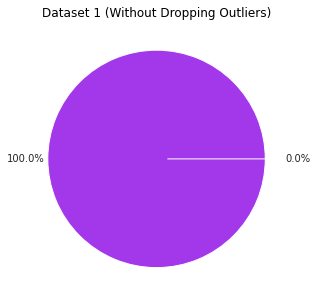


Inference: After the cleanup process, 0 samples were dropped, while retaining 0.0% of the data.


In [ ]:
#Final Dataset size after performing Preprocessing

df = data_enc.copy()
df.columns=[i.replace('-','_') for i in df.columns]

fig, ax = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid")
ax.set_title("Dataset 1 (Without Dropping Outliers)")
ax.pie([df.shape[0], original_data.shape[0]-df.shape[0]], radius = 1, labels=["Retained","Dropped"], counterclock=False,
        autopct="%1.1f%%", pctdistance = 1.2, labeldistance = None, explode=[0,0.1], colors = zenius)
# ax.legend(frameon=False, bbox_to_anchor=(0.9, 0.9))
plt.show()

print(f"\n\033[1mInference:\033[0m After the cleanup process, {original_data.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_data.shape[0])),2)}% of the data.")

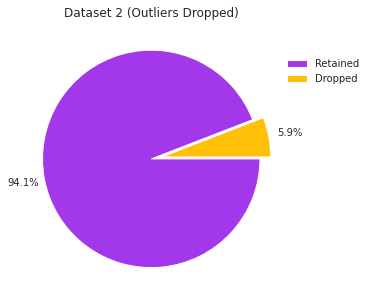


Inference: After the cleanup process, 378 samples were dropped, while retaining 5.87% of the data.


In [ ]:
#Final Dataset size after performing Preprocessing

df = data_dropped_outlier.copy()
df.columns=[i.replace("-","_") for i in df.columns]

fig, ax = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid")
ax.set_title("Dataset 2 (Outliers Dropped)")
ax.pie([df.shape[0], original_data.shape[0]-df.shape[0]], radius = 1, labels=["Retained","Dropped"], counterclock=False,
        autopct="%1.1f%%", pctdistance = 1.2, labeldistance = None, explode=[0,0.1], colors = zenius)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 0.9))
plt.show()

print(f"\n\033[1mInference:\033[0m After the cleanup process, {original_data.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_data.shape[0])),2)}% of the data.")

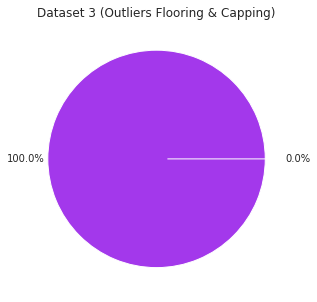


Inference: After the cleanup process, 0 samples were dropped, while retaining 0.0% of the data.


In [ ]:
#Final Dataset size after performing Preprocessing

df = data_enc.copy()
df.columns=[i.replace('-','_') for i in df.columns]

fig, ax = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid")
ax.set_title("Dataset 3 (Outliers Flooring & Capping)")
ax.pie([df.shape[0], original_data.shape[0]-df.shape[0]], radius = 1, labels=["Retained","Dropped"], counterclock=False,
        autopct="%1.1f%%", pctdistance = 1.2, labeldistance = None, explode=[0,0.1], colors = zenius)
plt.show()

print(f"\n\033[1mInference:\033[0m After the cleanup process, {original_data.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_data.shape[0])),2)}% of the data.")

# 3. Modeling

In [ ]:
features = [i for i in data_enc.columns if i not in [target]] #store all features name
print("Data target adalah: {}".format(target))
print("Data fitur berjumlah {} dan terdiri dari : {}".format(len(features), features))

Data target adalah: Weekly_Sales
Data fitur berjumlah 158 dan terdiri dari : ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'Before_Super_Bowl', 'Before_Labor_Day', 'Before_Thanksgiving', 'Before_Christmas', 'Unemployment_class', 'CPI_class', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16

Jumlah fitur pada dataset menjadi 151 setelah melalui proses dummy encoding. Fitur ini tentunya terlalu banyak untuk diproses dan belum tentu semuanya relevan sehingga kita perlu melakukan seleksi fitur terlebih dahulu.

Salah satu cara untuk melihat *feature improtance* adalah menggunakan koefisien yang dihasilkan oleh regressor (sumber: [feature importance for linear models -AnalyticsVidhya](https://medium.com/analytics-vidhya/feature-importance-explained-bfc8d874bcf#:~:text=Source-,What%20is%20Feature%20importance%20%3F,both%20classification%20and%20regression%20problem)). Oleh karena itu, kita akan menggunakan [RFE (Recursive Feature Elimination)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), salah satu metode *feature selection* yang paling sering digunakan. Dengan menggunakan *estimator* yang dapat menghasilkan nilai koefisien (yang dalam hal ini kita menggunakan koefisien dari model), RFE akan mengeliminasi fitur secara rekursif berdasarkan *feature importance* dari setiap fitur.

In [ ]:
# Set features and target values to seperated variables

# Data with outliers
y = data_enc[target]
X = data_enc[features]

# Data with outliers dropped
y_2 = data_drop_outlier_enc[target]
X_2 = data_drop_outlier_enc[features]

# Data with outliers floored and capped
y_3 = data_tf_outlier_enc[target]
X_3 = data_tf_outlier_enc[features]

In [ ]:
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.4, random_state = 42)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.4, random_state = 42)

In [ ]:
# Dataset with outliers
print("Original dataset :", X.shape, y.shape)
print("Training dataset :", X_train.shape, y_train.shape)
print("Testing dataset  :", X_test.shape,"", y_test.shape)
print("")

#Dataset with outliers removed
print("Original dataset 2 :", X_2.shape, y_2.shape)
print("Training dataset 2 :", X_train_2.shape, y_train_2.shape)
print("Testing dataset  2 :", X_test_2.shape,"", y_test_2.shape)
print("")

#Dataset with outliers floored and capped
print("Original dataset 3 :", X_3.shape, y_3.shape)
print("Training dataset 3 :", X_train_3.shape, y_train_3.shape)
print("Testing dataset  3 :", X_test_3.shape,"", y_test_3.shape)

Original dataset : (6435, 158) (6435,)
Training dataset : (3861, 158) (3861,)
Testing dataset  : (2574, 158)  (2574,)

Original dataset 2 : (6057, 158) (6057,)
Training dataset 2 : (3634, 158) (3634,)
Testing dataset  2 : (2423, 158)  (2423,)

Original dataset 3 : (6435, 158) (6435,)
Training dataset 3 : (3861, 158) (3861,)
Testing dataset  3 : (2574, 158)  (2574,)


## 3.1 Feature Selection

### 3.1.1 Feature Ranking using RFE (Recursive Feature Elimination)

Untuk menggunakan RFE, kita harus mengisi parameter n_features_to_select dengan jumlah fitur yang ingin kita pilih. Masalahnya, kita tidak mengetahui berapa jumlah fitur yang menghasilkan *performace* terbaik. Oleh karena itu kita akan melakukan looping untuk dengan seluruh kemungkinan jumlah fitur yang ada, lalu kita akan pilih jumlah fitur yang memiliki *performance* terbaik.  

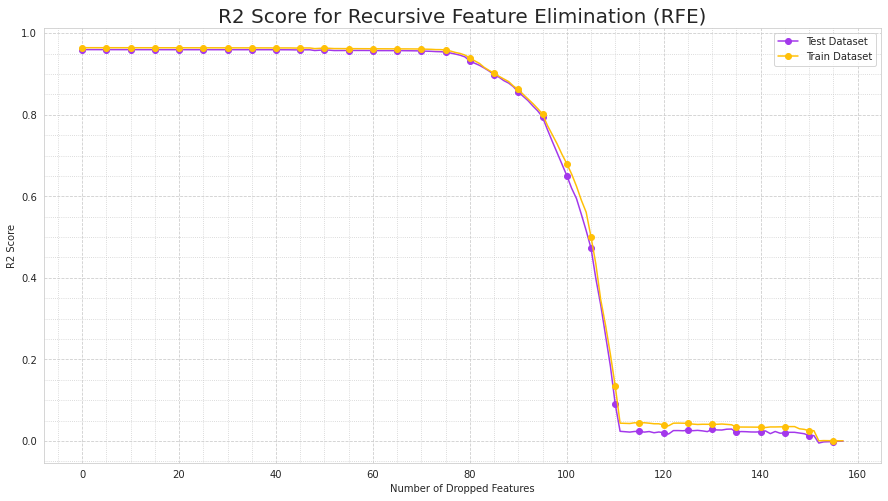

In [ ]:
# Feature Selection with RFE

rfe_train = []; rfe_test = []
# Looping through all the features
for i in range (len(features)):
    # Perform RFE
    rfe           = RFE(estimator = LinearRegression(), n_features_to_select = X_train.shape[1]-i)
    rfe           = rfe.fit(X_train, y_train)
    # Perform regression (Linear Regression here since it's the simplest one) with the selected features
    regressor     = LinearRegression()
    regressor.fit(X_train.loc[:,rfe.support_], y_train)
    # Predict the target values for the both training and testing sets
    y_pred_train  = regressor.predict(X_train.loc[:,rfe.support_])
    y_pred_test   = regressor.predict(X_test.loc[:,rfe.support_])
    # Calculate the r2 score
    r2_train      = r2_score(y_train, y_pred_train)
    r2_test       = r2_score(y_test, y_pred_test)
    # Store the evaluation results
    rfe_train.append(r2_train)
    rfe_test.append(r2_test)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(rfe_test, color = zenius[0], label = "Test Dataset", marker = 'o', markevery = 5)
plt.plot(rfe_train, color = zenius[1], label = "Train Dataset", marker = 'o', markevery = 5)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# Turn grid on for both major and minor ticks.
ax.grid(which = "major", linestyle = "--")
ax.grid(which = "minor", linestyle = ":")
plt.xlabel("Number of Dropped Features")
plt.ylabel("R2 Score")
plt.title ("R2 Score for Recursive Feature Elimination (RFE)", fontsize = 20)
plt.legend()
plt.show()

Berdasarkan grafik RFE di atas, nilai R2 Score mulai turun drastis saat jumlah fitur yang di-drop >75, yang berarti ada sekitar 76 (151-75) fitur yang memiliki *importance* yang lebih tinggi dibanding fitur-fitur lainnya.

### 3.1.2 Feature Decomposition using PCA (Principal Component Analysis)

Tidak seperti RFE yang akan mengeliminasi fitur dengan nilai koefisien terendah, PCA akan mengombinasikan fitur-fitur sebanyak n-component sesuai dengan nilai *variance* dari tiap fiturnya, sehingga setiap fitur tetap memiliki peran dalam modeling sesuai dengan kontribusinya masing-masing.

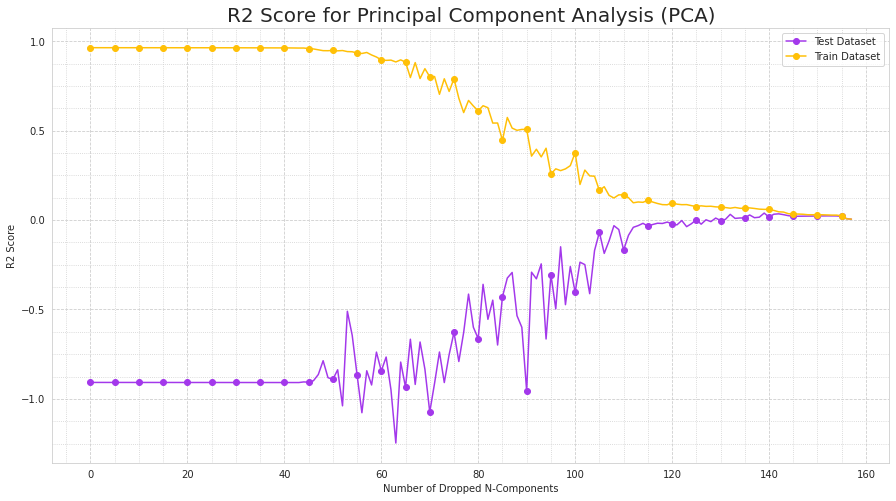

In [ ]:
# Feature Selection with PCA

pca_train = []; pca_test = []
# Looping through all the features
for i in range (len(features)):
    # Perform PCA
    pca           = PCA(n_components = X_train.shape[1]-i)
    X_train_pca   = pca.fit_transform(X_train)
    X_test_pca    = pca.fit_transform(X_test)
    # Predict the target values for the both training and testing sets
    regressor     = LinearRegression()
    regressor.fit(X_train_pca, y_train)
    y_pred_train  = regressor.predict(X_train_pca)
    y_pred_test   = regressor.predict(X_test_pca)
    # Calculate the r2 score
    r2_train      = r2_score(y_train, y_pred_train)
    r2_test       = r2_score(y_test, y_pred_test)
    # Store the evaluation results
    pca_train.append(r2_train)
    pca_test.append(r2_test)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(pca_test, color = zenius[0], label = "Test Dataset", marker = 'o', markevery = 5)
plt.plot(pca_train, color = zenius[1], label = "Train Dataset", marker = 'o', markevery = 5)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# Turn grid on for both major and minor ticks.
ax.grid(which = "major", linestyle = "--")
ax.grid(which = "minor", linestyle = ":")
plt.xlabel("Number of Dropped N-Components")
plt.ylabel("R2 Score")
plt.title ("R2 Score for Principal Component Analysis (PCA)", fontsize = 20)
plt.legend()
plt.show()

Ternyata PCA memiliki *performance* yang cenderung tidak stabil dibandingkan RFE karena R2 Score pada testing dataset-nya naik-turun secara drastis dan tidak teratur seiring dengan bertambahnya jumlah N-Component yang di-drop sehingga sepertinya lebih aman untuk menggunakan RFE.

In [ ]:
rfe_final   = RFE(estimator = LinearRegression(), n_features_to_select = X_train.shape[1]-75) # Train with choosen number of features
rfe_final   = rfe_final.fit(X_train, y_train)
rfe_result  = pd.DataFrame(data = rfe_final.feature_names_in_, columns = ["Features"]) # Feature names
rfe_result["Selected"] = rfe_final.support_ # RFE selected value of each feature (True/False)
rfe_result["Ranking"]  = rfe_final.ranking_ # RFE ranking of each feature

pd.set_option("display.max_rows", 500) # Show all rows
rfe_result.sort_values(by = "Ranking", ignore_index = True) # Sort feature order by ranking

,Features,Selected,Ranking
0,Holiday_Flag,True,1
1,Month_12,True,1
2,Month_11,True,1
3,Month_10,True,1
4,Month_9,True,1
5,Month_8,True,1
6,Month_7,True,1
7,Month_6,True,1
8,Month_5,True,1
9,Month_4,True,1


Berdasarkan hasil *feature ranking* di atas, fitur yang memiliki *ranking* yang sangat rendah adalah fitur "Temperature", "Day", "CPI", "Fuel Price", "Unemployment", dan beberapa fitur "WeekOfYear". Namun, tidak masuk akal jika kita hanya menghapus beberapa fitur dari keseluruhan fitur kategorikal, tepatnya pada fitur "WeekOfYear" (seperti menghapus "WeekOfYear_19" dan "WeekOfYear_10" tetapi tidak dengan yang lainnnya) karena sama saja membuat distribusi fitur menjadi tidak merata dan juga masih terdapat beberapa fitur WeekOfYear dengan *ranking* tinggi. Oleh karena itu, kita akan menyeleksi fitur numerik saja dan fitur kategorikal yang keseluruhan fitur-fitur encoded-nya memiliki *ranking* yang rendah.

In [ ]:
# Function to do prediction for each training and testing test
def PredictData (model, X_train, X_test):
    dataset = {"y_train" : model.predict(X_train),  # Prediction with training dataset
               "y_test"  : model.predict(X_test)}   # Prediction with testing dataset
    return dataset

In [ ]:
# Function to evaluate model
def EvaluateModel (y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    nrmse = rmse/np.std(y_pred)
    r2 = r2_score(y_test, y_pred)


    eval_metric = {"MAE" : mae,
                   "MSE" : mse,
                   "RMSE" : rmse,
                   "MAPE" : mape,
                   "NRMSE" : nrmse,
                   "R2_Score": r2}

    return eval_metric

In [ ]:
# Evaluation Metric Comparison for different Regression Models
def PlotMetric (eval_train, eval_test, metric, idx, top_result, model_title, figsize, legend_coor, float_limit):

    fig, ax = plt.subplots(figsize = figsize)
    # Store evaluation result for each training and testing set
    eval_train = eval_train[metric]
    eval_test  = eval_test[metric]

    # If it's R2_Score sort with the highest value first, if not (which means it's error rate) sort with the lowest value first
    ascending_val       = np.where(metric == "R2_Score", False, True)
    eval_train_sorted   = eval_train.sort_values(ascending = bool(ascending_val))
    eval_test_sorted    = eval_test.sort_values(ascending = bool(ascending_val))

    # Default value for lineweight, dot size, and fontweight
    lw_train    = np.full((len(eval_train)), 1)
    lw_test     = np.full((len(eval_train)), 1)
    size_train  = np.full((len(eval_train)), 50)
    size_test   = np.full((len(eval_train)), 50)
    fw_train    = ["normal"]*len(eval_train)
    fw_test     = ["normal"]*len(eval_train)

    # Make linewidth, dot size, and fontweight stand out for 3 top metric scores (lowest error/highest performance)
    for x in range(len(eval_train)):
        for n in range(top_result):
            if(eval_train[x] == eval_train_sorted[n]): #If value is the best score(at n-th index of sorted values)
                lw_train[x] = 3; size_train[x] = 160; fw_train[x] = "semibold"
            if(eval_test[x] == eval_test_sorted[n]):
                lw_test[x] = 3; size_test[x] = 160; fw_test[x] = "semibold"

    # Function to keep the line and dot inside the plot if the score is <0 or >100
    def FindXCoor(eval_data):
        return np.where(((eval_data.values*100) > 100), 1.03,
               np.where(((eval_data.values*100) < 0), 0, eval_data.values))
    # Store the custom x coordinates for each dataset
    x_coor_test = FindXCoor(eval_test)
    x_coor_train = FindXCoor(eval_train)

    # Plot horizontal lines
    plt.hlines(y = np.arange(len(eval_test.index))+0.2, xmin = 0, xmax = x_coor_test, color = zenius[0], alpha = 0.5, linewidth = lw_test)
    plt.hlines(y = np.arange(len(eval_train.index))-0.2, xmin = 0, xmax = x_coor_train, color = zenius[1], alpha = 0.5, linewidth = lw_train)

    # Plot dots
    ax.scatter(x = x_coor_test, y = np.arange(len(eval_test.index))+0.2, color = zenius[0], s = size_test, alpha = 1, label = "Test Data")
    ax.scatter(x = x_coor_train, y = np.arange(len(eval_test.index))-0.2, color = zenius[1], s = size_train, alpha = 1, label = "Training Data")

    # Plot text (percentage)
    for i, v in enumerate(eval_test):
        plt.text(x_coor_test[i] + 0.05, i+0.15, str("{:.{}f}%".format(v*100, float_limit)), color="black", fontsize = 12, fontweight = fw_test[i])
    for i, v in enumerate(eval_train):
        plt.text(x_coor_train[i] +0.05, i-0.25, str("{:.{}f}%".format(v*100, float_limit)), color="black", fontsize = 12, fontweight = fw_train[i])

    ax.set_yticks(np.arange(len(eval_test.index)))
    ax.set_yticklabels(np.array(idx))
    ax.set_xlim([0, 1]) # Set x-axis limit from 0 to 1
    ax.set_title("{} for {}".format(metric, model_title), fontsize = 20)
    bigger_ticks_font_size(ax)
    bigger_label_font_size(ax, metric, None)
    handles, labels = ax.get_legend_handles_labels() # Get legend handle for figure (so it can be located outside the plot)
    fig.legend(handles, labels, bbox_to_anchor = legend_coor, bbox_transform = ax.transAxes, title = "Dataset") # Set Legend
    plt.show()

In [ ]:
cols_to_drop = ["Temperature", "CPI", "Fuel_Price", "Unemployment", "Day_1", "Day_2", "Day_3", "Day_4", "Day_5",
                "Day_6", "Day_7", "Day_8", "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14", "Day_15",
                "Day_16", "Day_17", "Day_18", "Day_19", "Day_20", "Day_21", "Day_22", "Day_23", "Day_24", "Day_25",
                "Day_26", "Day_27", "Day_28", "Day_29", "Day_30", "Day_31"]

# Drop selected column (with lowest importance feature)
data_selected    = data_enc.drop(cols_to_drop, axis = 1)
new_features     = [i for i in data_selected.columns if i not in [target]] #store all features name
# Dataset splitting
y_selected       = data_selected[target]
X_selected       = data_selected[new_features]
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size = 0.4, random_state = 42)

# Perform linear regression (LR)
regressor        = LinearRegression()
# LR: Raw data
start = time.time()
regressor.fit(X_train, y_train)
end = time.time()
lr_pred          = PredictData(regressor, X_train, X_test)
# LR: Selected data
start_selected = time.time()
regressor.fit(X_train_selected, y_train_selected)
end_selected = time.time()
lr_pred_selected = PredictData(regressor, X_train_selected, X_test_selected)
# Evaluation result
data_train = pd.DataFrame.from_dict({"raw"      : EvaluateModel(y_train, lr_pred["y_train"]),
                                    "selected" : EvaluateModel (y_train_selected, lr_pred_selected["y_train"])}).transpose()
data_test = pd.DataFrame.from_dict({"raw"      : EvaluateModel(y_test, lr_pred["y_test"]),
                                    "selected" : EvaluateModel (y_test_selected, lr_pred_selected["y_test"])}).transpose()
data_idx = ["Data", "Data (RFE)"]

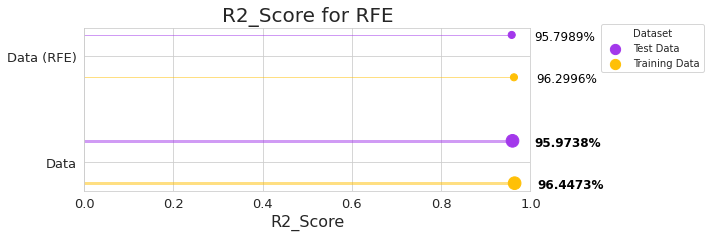

In [ ]:
PlotMetric (data_train, data_test, metric = "R2_Score", idx = data_idx, top_result = 1, model_title = "RFE",
            figsize = [8, 3], legend_coor =(1.4, 1.05), float_limit = 4)

In [ ]:
time_raw      = end-start
time_selected = end_selected-start_selected

print("Data (No Feature Selection)")
print("Time elapsed: {:.5f} seconds. R2 Score: {:.5f}".format(time_raw, data_train["R2_Score"][0]))
print("Data (Recursive Feature Elimination)")
print("Time elapsed: {:.5f} seconds. R2 Score: {:.5f}".format(time_selected, data_train["R2_Score"][1]))

Data (No Feature Selection)
Time elapsed: 0.04978 seconds. R2 Score: 0.96447
Data (Recursive Feature Elimination)
Time elapsed: 0.03930 seconds. R2 Score: 0.96300


Waktu komputasi pada data dengan RFE malah memakan waktu sedikit lebih lama dibandingkan data tanpa RFE. Oleh karena itu, kami memutuskan untuk melanjutkan proses modeling dengan menggunakan semua fitur yang ada. Tetapi, untuk ke depannya, waktu komputasi dapat menjadi pertimbangan bagi pihak Walmart karena seiring bertambahnya waktu semakin banyak data yang harus diproses sehingga *computational cost* juga perlu diperhatikan.

## 3.2 Training Data

Ada 4 metode regresi yang akan kita pakai di sini, yaitu Linear Regression, Ridge Regression, Lasso dan Elastic Net.

### 3.2.1 Linear Regression

#### 3.2.1.1 Dataset 1 (With Outliers)

In [ ]:
def ScaleData (scaler, X_train, X_test, y_train, y_test, col_names):

    # Standardize the features
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns= col_names)
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns= col_names)

    # Standardize the target
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1)) # Reshape it into 2D array so it can be processed
    y_test  = scaler.transform(y_test.values.reshape(-1,1))

    dataset = {"X_train" : X_train,
               "X_test"  : X_test,
               "y_train" : y_train,
               "y_test"  : y_test}

    return dataset

In [ ]:
# Create linear regression object
LinReg = LinearRegression()

# Dataset 1
LinReg.fit(X_train, y_train) # Train the model using the training sets
linreg_pred = PredictData(LinReg, X_train, X_test) # Predict the test set and train set

# Dataset 1 Standardized
data_std        = ScaleData(StandardScaler(), X_train, X_test, y_train, y_test, features)
LinReg.fit(data_std["X_train"], data_std["y_train"])
linreg_std_pred     = PredictData(LinReg, data_std["X_train"], data_std["X_test"])

# Dataset 1 Normalized
data_norm       = ScaleData(MinMaxScaler(), X_train, X_test, y_train, y_test, features)
LinReg.fit(data_norm["X_train"], data_norm["y_train"])
linreg_norm_pred    = PredictData(LinReg, data_norm["X_train"], data_norm["X_test"])

# Dataset 1 Robust Scaler
data_robs       = ScaleData(RobustScaler(), X_train, X_test, y_train, y_test, features)
LinReg.fit(data_robs["X_train"], data_robs["y_train"])
linreg_robs_pred    = PredictData(LinReg, data_robs["X_train"], data_robs["X_test"])

In [ ]:
# Standardized features for training dataset
data_std["X_train"].head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2010,Year_2011,Year_2012,WeekOfYear_1,WeekOfYear_2,WeekOfYear_3,WeekOfYear_4,WeekOfYear_5,WeekOfYear_6,WeekOfYear_7,WeekOfYear_8,WeekOfYear_9,WeekOfYear_10,WeekOfYear_11,WeekOfYear_12,WeekOfYear_13,WeekOfYear_14,WeekOfYear_15,WeekOfYear_16,WeekOfYear_17,WeekOfYear_18,WeekOfYear_19,WeekOfYear_20,WeekOfYear_21,WeekOfYear_22,WeekOfYear_23,WeekOfYear_24,WeekOfYear_25,WeekOfYear_26,WeekOfYear_27,WeekOfYear_28,WeekOfYear_29,WeekOfYear_30,WeekOfYear_31,WeekOfYear_32,WeekOfYear_33,WeekOfYear_34,WeekOfYear_35,WeekOfYear_36,WeekOfYear_37,WeekOfYear_38,WeekOfYear_39,WeekOfYear_40,WeekOfYear_41,WeekOfYear_42,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,-0.271465,0.249180,0.942717,-0.893308,-1.828006,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,-2.046188,-0.564220,-0.142649,-0.144528,-0.138821,-0.143592,-0.15183,-0.147305,-0.16306,-0.14913,-0.147305,-0.146385,-0.147305,-0.157104,-0.155364,-0.150935,-0.157104,-0.15183,-0.154487,-0.15183,-0.143592,-0.154487,-0.144528,-0.146385,-0.144528,-0.143592,-0.15183,-0.154487,-0.154487,-0.14913,-0.159681,-0.157104,-0.141701,-0.157104,-0.142649,-0.164727,-0.145459,-0.150035,-0.15183,-0.150935,-0.155364,6.788620,-0.150935,-0.154487,-0.154487,-0.15183,-0.156236,-0.174426,-0.176777,-0.196827,-0.195403,-0.187405,-0.191803,-0.165554,-0.162221,-0.188881,-0.197536,-0.180635,-0.185919,-0.196827,-0.168828,-0.165554,-0.186663,-0.187405,-0.19325,-0.191076,-0.189615,-0.170444,-0.166378,-0.191076,-0.188881,-0.196116,5.155441,-0.187405,-0.170444,-0.178329,-0.194688,-0.121316,-0.245811,-0.304695,-0.322139,-0.329435,-0.298563,-0.311247,-0.327499,3.132910,-0.318206,-0.317712,-0.240433,-0.270914,-0.700524,1.331806,-0.670722,-0.116841,-0.123495,-0.119098,-0.121316,-0.145459,-0.144528,-0.150935,-0.14822,-0.145459,-0.137849,-0.155364,-0.155364,-0.143592,-0.146385,-0.142649,-0.150035,-0.150935,-0.15183,-0.14913,-0.134893,-0.141701,-0.150035,-0.143592,-0.145459,-0.135885,-0.142649,-0.145459,-0.139787,-0.144528,-0.156236,-0.143592,-0.14822,-0.14913,6.874773,-0.15183,-0.14822,-0.138821,-0.154487,-0.15183,-0.141701,-0.143592,-0.147305,-0.150035,-0.116841,-0.112199,-0.121316,-0.120212,-0.113376,-0.126699,-0.119098,-0.116841,-0.112199
1,-0.271465,1.323784,0.618420,1.200529,-0.241017,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,0.020609,1.846461,-0.142649,-0.144528,7.203500,-0.143592,-0.15183,-0.147305,-0.16306,-0.14913,-0.147305,-0.146385,-0.147305,-0.157104,-0.155364,-0.150935,-0.157104,-0.15183,-0.154487,-0.15183,-0.143592,-0.154487,-0.144528,-0.146385,-0.144528,-0.143592,-0.15183,-0.154487,-0.154487,-0.14913,-0.159681,-0.157104,-0.141701,-0.157104,-0.142649,-0.164727,-0.145459,-0.150035,-0.15183,-0.150935,-0.155364,-0.147305,-0.150935,-0.154487,-0.154487,-0.15183,-0.156236,-0.174426,-0.176777,-0.196827,-0.195403,-0.187405,-0.191803,-0.165554,-0.162221,-0.188881,5.062370,-0.180635,-0.185919,-0.196827,-0.168828,-0.165554,-0.186663,-0.187405,-0.19325,-0.191076,-0.189615,-0.170444,-

In [ ]:
# Normalized features for training dataset
data_norm["X_train"].head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2010,Year_2011,Year_2012,WeekOfYear_1,WeekOfYear_2,WeekOfYear_3,WeekOfYear_4,WeekOfYear_5,WeekOfYear_6,WeekOfYear_7,WeekOfYear_8,WeekOfYear_9,WeekOfYear_10,WeekOfYear_11,WeekOfYear_12,WeekOfYear_13,WeekOfYear_14,WeekOfYear_15,WeekOfYear_16,WeekOfYear_17,WeekOfYear_18,WeekOfYear_19,WeekOfYear_20,WeekOfYear_21,WeekOfYear_22,WeekOfYear_23,WeekOfYear_24,WeekOfYear_25,WeekOfYear_26,WeekOfYear_27,WeekOfYear_28,WeekOfYear_29,WeekOfYear_30,WeekOfYear_31,WeekOfYear_32,WeekOfYear_33,WeekOfYear_34,WeekOfYear_35,WeekOfYear_36,WeekOfYear_37,WeekOfYear_38,WeekOfYear_39,WeekOfYear_40,WeekOfYear_41,WeekOfYear_42,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,0.0,0.656262,0.656090,0.100324,0.067568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.850294,0.580348,0.912730,0.354131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.839628,0.078813,0.879270,0.240081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.544129,0.208291,0.097393,0.495687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0

In [ ]:
# Normalized features for training dataset
data_robs["X_train"].head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2010,Year_2011,Year_2012,WeekOfYear_1,WeekOfYear_2,WeekOfYear_3,WeekOfYear_4,WeekOfYear_5,WeekOfYear_6,WeekOfYear_7,WeekOfYear_8,WeekOfYear_9,WeekOfYear_10,WeekOfYear_11,WeekOfYear_12,WeekOfYear_13,WeekOfYear_14,WeekOfYear_15,WeekOfYear_16,WeekOfYear_17,WeekOfYear_18,WeekOfYear_19,WeekOfYear_20,WeekOfYear_21,WeekOfYear_22,WeekOfYear_23,WeekOfYear_24,WeekOfYear_25,WeekOfYear_26,WeekOfYear_27,WeekOfYear_28,WeekOfYear_29,WeekOfYear_30,WeekOfYear_31,WeekOfYear_32,WeekOfYear_33,WeekOfYear_34,WeekOfYear_35,WeekOfYear_36,WeekOfYear_37,WeekOfYear_38,WeekOfYear_39,WeekOfYear_40,WeekOfYear_41,WeekOfYear_42,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,0.0,0.090313,0.419274,-0.577203,-1.941415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.812454,0.234043,0.445426,-0.207077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.772760,-0.992491,0.403308,-0.897332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.327021,-0.675845,-0.580893,0.649652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
def DescribeNumpyArray(arr):
    # measures of central tendency
    mean = np.mean(arr)
    median = np.median(arr)

    # measures of dispersion
    min = np.amin(arr)
    max = np.amax(arr)
    range = np.ptp(arr)
    variance = np.var(arr)
    sd = np.std(arr)

    print("Descriptive analysis")
    print("Array =", arr)
    print("____________________________")
    print("Measures of Central Tendency")
    print("Mean =", mean)
    print("Median =", median)
    print("____________________________")
    print("Measures of Dispersion")
    print("Minimum =", min)
    print("Maximum =", max)
    print("Range =", range)
    print("Variance =", variance)
    print("Standard Deviation =", sd)

In [ ]:
DescribeNumpyArray(data_std["y_train"])

Descriptive analysis
Array = [[-0.12441471]
 [-1.14799784]
 [-0.91586201]
 ...
 [-0.93698676]
 [-1.23472566]
 [-0.94411839]]
____________________________
Measures of Central Tendency
Mean = 3.128522794074515e-17
Median = -0.154525297245457
____________________________
Measures of Dispersion
Minimum = -1.4697024502077884
Maximum = 4.797954762135587
Range = 6.267657212343376
Variance = 0.9999999999999998
Standard Deviation = 0.9999999999999999


In [ ]:
DescribeNumpyArray(data_norm["y_train"])

Descriptive analysis
Array = [[0.21463965]
 [0.05132773]
 [0.08836483]
 ...
 [0.08499439]
 [0.03749037]
 [0.08385654]]
____________________________
Measures of Central Tendency
Mean = 0.23448992189831175
Median = 0.20983552680134657
____________________________
Measures of Dispersion
Minimum = 0.0
Maximum = 1.0000000000000002
Range = 1.0000000000000002
Variance = 0.02545596279441156
Standard Deviation = 0.15954924880553828


In [ ]:
DescribeNumpyArray(data_robs["y_train"])

Descriptive analysis
Array = [[ 0.01981757]
 [-0.65386349]
 [-0.50108107]
 ...
 [-0.51498453]
 [-0.71094424]
 [-0.51967828]]
____________________________
Measures of Central Tendency
Mean = 0.10170230803970763
Median = 0.0
____________________________
Measures of Dispersion
Minimum = -0.865596470750637
Maximum = 3.2595223017730746
Range = 4.125118772523711
Variance = 0.43317406090155713
Standard Deviation = 0.6581596013897824


#### 3.2.1.2. Dataset 2 (Outliers Dropped)

In [ ]:
# Dataset 2
LinReg.fit(X_train_2, y_train_2)
linreg_pred_2       = PredictData(LinReg, X_train_2, X_test_2) # Predict the test set and train set

# Dataset 2 Standardized
data_std_2        = ScaleData(StandardScaler(), X_train_2, X_test_2, y_train_2, y_test_2, features)
LinReg.fit(data_std_2["X_train"], data_std_2["y_train"])
linreg_std_pred_2   = PredictData(LinReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
data_norm_2       = ScaleData(MinMaxScaler(), X_train_2, X_test_2, y_train_2, y_test_2, features)
LinReg.fit(data_norm_2["X_train"], data_norm_2["y_train"])
linreg_norm_pred_2  = PredictData(LinReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
data_robs_2       = ScaleData(RobustScaler(), X_train_2, X_test_2, y_train_2, y_test_2, features)
LinReg.fit(data_robs_2["X_train"], data_robs_2["y_train"])
linreg_robs_pred_2  = PredictData(LinReg, data_robs_2["X_train"], data_robs_2["X_test"])

#### 3.2.1.3 Dataset 3 (Outliers Transformed)

In [ ]:
# Dataset 3
LinReg.fit(X_train_3, y_train_3)
linreg_pred_3 = PredictData(LinReg, X_train_3, X_test_3) # Predict the test set and train set

# Dataset 3 Standardized
data_std_3           = ScaleData(StandardScaler(), X_train_3, X_test_3, y_train_3, y_test_3, features)
LinReg.fit(data_std_3["X_train"], data_std_3["y_train"])
linreg_std_pred_3   = PredictData(LinReg, data_std_3["X_train"], data_std_3["X_test"])

# Dataset 3 Normalized
data_norm_3          = ScaleData(MinMaxScaler(), X_train_3, X_test_3, y_train_3, y_test_3, features)
LinReg.fit(data_norm_3["X_train"], data_norm_3["y_train"])
linreg_norm_pred_3   = PredictData(LinReg, data_norm_3["X_train"], data_norm_3["X_test"])

# Dataset 3 Robust Scaler
data_robs_3           = ScaleData(RobustScaler(), X_train_3, X_test_3, y_train_3, y_test_3, features)
LinReg.fit(data_robs_3["X_train"], data_robs_3["y_train"])
linreg_robs_pred_3   = PredictData(LinReg, data_robs_3["X_train"], data_robs_3["X_test"])

#### 3.2.1.4 Evaluation for Linear Regression

In [ ]:
def StoreEvaluationResult(y, y_pred, y_std, y_std_pred, y_norm, y_norm_pred, y_robs, y_robs_pred):
    dataset = {"raw"     : EvaluateModel(y, y_pred),
               "std"     : EvaluateModel(y_std, y_std_pred),
               "norm"    : EvaluateModel(y_norm, y_norm_pred),
               "robs"    : EvaluateModel(y_robs, y_robs_pred)}
    return dataset

In [ ]:
# Training sets
linreg_train   = StoreEvaluationResult(y_train, linreg_pred["y_train"], data_std["y_train"], linreg_std_pred["y_train"],
                                    data_norm["y_train"], linreg_norm_pred["y_train"], data_robs["y_train"], linreg_robs_pred["y_train"])

linreg_train_2 = StoreEvaluationResult(y_train_2, linreg_pred_2["y_train"], data_std_2["y_train"], linreg_std_pred_2["y_train"],
                                    data_norm_2["y_train"], linreg_norm_pred_2["y_train"], data_robs_2["y_train"], linreg_robs_pred_2["y_train"])

linreg_train_3 = StoreEvaluationResult(y_train_3, linreg_pred_3["y_train"], data_std_3["y_train"], linreg_std_pred_3["y_train"],
                                    data_norm_3["y_train"], linreg_norm_pred_3["y_train"], data_robs_3["y_train"], linreg_robs_pred_3["y_train"])

# Test sets
linreg_test    = StoreEvaluationResult(y_test, linreg_pred["y_test"], data_std["y_test"], linreg_std_pred["y_test"],
                                    data_norm["y_test"], linreg_norm_pred["y_test"], data_robs["y_test"], linreg_robs_pred["y_test"])

linreg_test_2  = StoreEvaluationResult(y_test_2, linreg_pred_2["y_test"], data_std_2["y_test"], linreg_std_pred_2["y_test"],
                                    data_norm_2["y_test"], linreg_norm_pred_2["y_test"], data_robs_2["y_test"], linreg_robs_pred_2["y_test"])

linreg_test_3  = StoreEvaluationResult(y_test_3, linreg_pred_3["y_test"], data_std_3["y_test"], linreg_std_pred_3["y_test"],
                                    data_norm_3["y_test"], linreg_norm_pred_3["y_test"], data_robs_3["y_test"], linreg_robs_pred_3["y_test"])

In [ ]:
idx =  ["Data 1: With Outliers", "Data 1: With Outliers (Standardized)",
                "Data 1: With Outliers (Normalized)", "Data 1: With Outliers (Robust Scaler)",
                "Data 2: Outliers Dropped", "Data 2: Outliers Dropped (Standardized)",
                "Data 2: Outliers Dropped (Normalized)", "Data 2: Outliers Dropped (Robust Scaler)",
                "Data 3: Outliers Transformed", "Data 3: Outliers Transformed (Standardized)",
                "Data 3: Outliers Transformed (Normalized)", "Data 3: Outliers Transformed (Robust Scaler)"]

In [ ]:
# Evaluation for Training Data
linreg_eval_train       = pd.DataFrame.from_dict([linreg_train["raw"], linreg_train["std"], linreg_train["norm"], linreg_train["robs"],
                                                    linreg_train_2["raw"], linreg_train_2["std"], linreg_train_2["norm"], linreg_train_2["robs"],
                                                    linreg_train_3["raw"], linreg_train_3["std"], linreg_train_3["norm"], linreg_train_3["robs"]])
linreg_eval_train.index = idx
print(f'{"LINEAR REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
linreg_eval_train

                                 LINEAR REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data 1: With Outliers,68238.819469,1.132722e+10,106429.424305,8.122735e-02,0.191925,0.964473
Data 1: With Outliers (Standardized),0.129793,3.790903e-02,0.194702,4.901823e-01,0.196035,0.962091
Data 1: With Outliers (Normalized),0.019265,9.050430e-04,0.030084,2.790783e+10,0.192012,0.964447
Data 1: With Outliers (Robust Scaler),0.079547,1.539028e-02,0.124058,6.606752e+10,0.191949,0.964471
Data 2: Outliers Dropped,67807.677767,1.145789e+10,107041.514902,8.082154e-02,0.191081,0.964774
Data 2: Outliers Dropped (Standardized),0.119428,3.552906e-02,0.188492,4.689783e-01,0.192152,0.964471
Data 2: Outliers Dropped (Normalized),0.019066,9.059024e-04,0.030098,2.617164e+10,0.191103,0.964768
Data 2: Outliers Dropped (Robust Scaler),0.077538,1.498175e-02,0.122400,1.266244e+00,0.191080,0.964774
Data 3: Outliers Transformed,68544.853029,1.141967e+10,106862.836465,8.185907e-02,0.192736,0.964183
Data 3: Outliers Transformed (Standardized),0.121927,3.593322e-02,0.189561,4.331943e-01,0.192910,0.964067


In [ ]:
# Evaluation for Data Testing
linreg_eval_test       = pd.DataFrame.from_dict([linreg_test["raw"], linreg_test["std"], linreg_test["norm"], linreg_test["robs"],
                                                    linreg_test_2["raw"], linreg_test_2["std"], linreg_test_2["norm"], linreg_test_2["robs"],
                                                    linreg_test_3["raw"], linreg_test_3["std"], linreg_test_3["norm"], linreg_test_3["robs"]])
linreg_eval_test.index = idx
print(f'{"LINEAR REGRESSION (BASE MODEL) - TEST DATA EVALUATION":^120s}')
linreg_eval_test

                                 LINEAR REGRESSION (BASE MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data 1: With Outliers,72430.852282,1.279156e+10,113099.783995,0.084810,0.203279,0.959738
Data 1: With Outliers (Standardized),0.137292,4.251062e-02,0.206181,0.618329,0.206965,0.957338
Data 1: With Outliers (Normalized),0.020442,1.021287e-03,0.031958,0.178262,0.203309,0.959738
Data 1: With Outliers (Robust Scaler),0.084419,1.737658e-02,0.131820,0.576225,0.203292,0.959743
Data 2: Outliers Dropped,72059.134925,1.236687e+10,111206.423230,0.086063,0.195267,0.962210
Data 2: Outliers Dropped (Standardized),0.126423,3.805283e-02,0.195071,0.559473,0.195750,0.962177
Data 2: Outliers Dropped (Normalized),0.020252,9.769126e-04,0.031256,0.194217,0.195222,0.962237
Data 2: Outliers Dropped (Robust Scaler),0.082394,1.616933e-02,0.127159,0.610333,0.195260,0.962212
Data 3: Outliers Transformed,72888.702352,1.293221e+10,113719.868887,0.085468,0.204341,0.959295
Data 3: Outliers Transformed (Standardized),0.128975,4.050433e-02,0.201257,0.488858,0.204079,0.959352


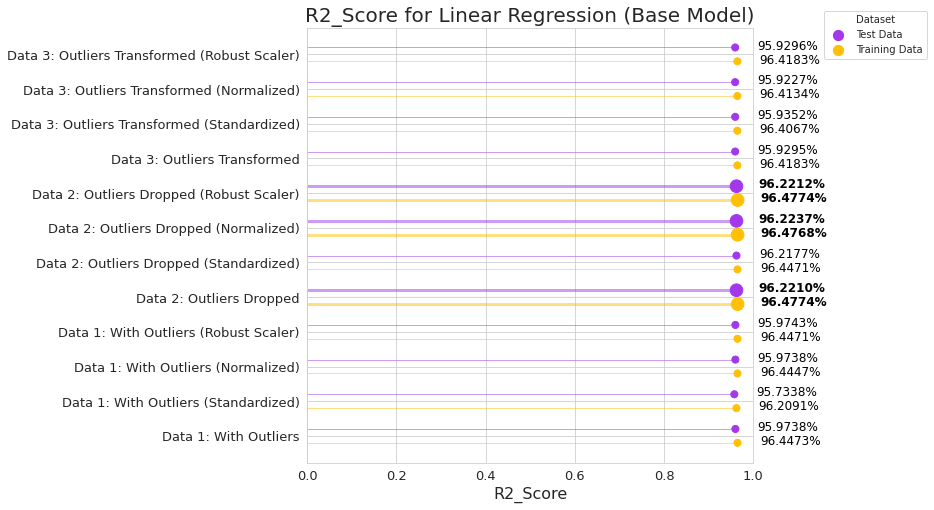

In [ ]:
PlotMetric(eval_train = linreg_eval_train, eval_test = linreg_eval_test, metric = "R2_Score", idx = idx, top_result = 3,
           model_title = "Linear Regression (Base Model)", figsize = [8, 8], legend_coor =(1.4, 1.05), float_limit = 4)

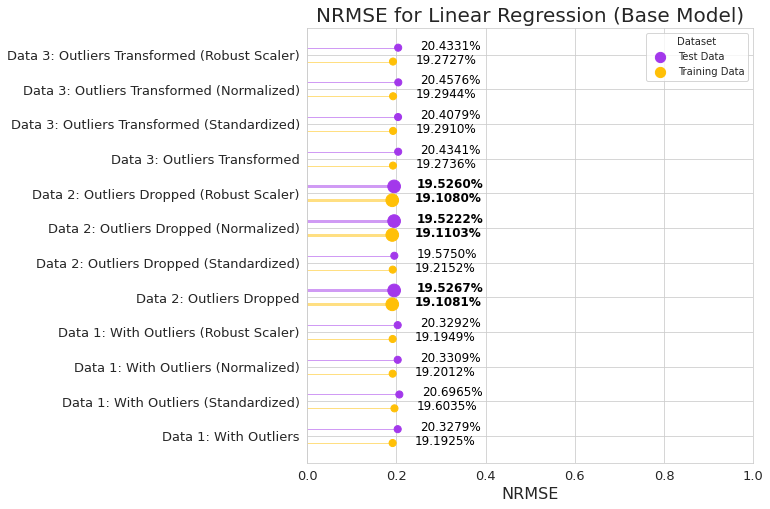

In [ ]:
PlotMetric(eval_train = linreg_eval_train, eval_test = linreg_eval_test, metric = "NRMSE", idx = idx, top_result = 3,
           model_title = "Linear Regression (Base Model)", figsize = [8, 8], legend_coor =(1, 1), float_limit = 4)

Berdasarkan hasil evaluasi, bisa kita simpulkan bahwa dataset dengan *performance* terbaik baik dari R2 Score maupun NRMSE adalah dataset kedua yang seluruh outlier-nya telah di-drop. Oleh karena itu kita akan menggunakan dataset ke-2 untuk proses modeling selanjutnya.

### 3.2.2 Ridge Regression

#### 3.2.2.1 Ridge Regression: Base Model

In [ ]:
RidgeReg = Ridge()

# Dataset 2
RidgeReg.fit(X_train_2, y_train_2)
ridreg_pred      = PredictData(RidgeReg, X_train_2, X_test_2) # Predict the test set and train set

# Dataset 2 Standardized
RidgeReg.fit(data_std_2["X_train"], data_std_2["y_train"])
ridreg_std_pred  = PredictData(RidgeReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
RidgeReg.fit(data_norm_2["X_train"], data_norm_2["y_train"])
ridreg_norm_pred = PredictData(RidgeReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
RidgeReg.fit(data_robs_2["X_train"], data_robs_2["y_train"])
ridreg_robs_pred = PredictData(RidgeReg, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
ridreg_train = StoreEvaluationResult(y_train_2, ridreg_pred["y_train"],
                                     data_std_2["y_train"], ridreg_std_pred["y_train"],
                                     data_norm_2["y_train"], ridreg_norm_pred["y_train"],
                                     data_robs_2["y_train"], ridreg_robs_pred["y_train"])
ridreg_test  = StoreEvaluationResult(y_test_2, ridreg_pred["y_test"],
                                     data_std_2["y_test"], ridreg_std_pred["y_test"],
                                     data_norm_2["y_test"], ridreg_norm_pred["y_test"],
                                     data_robs_2["y_test"], ridreg_robs_pred["y_test"])

In [ ]:
# Evaluation Result for Training Data
new_idx                 = ["Data", "Data (Standardized)", "Data (Normalized)", "Data (Robust Scaler)"]
ridreg_eval_train       = pd.DataFrame.from_dict([ridreg_train["raw"], ridreg_train["std"], ridreg_train["norm"], ridreg_train["robs"],])
ridreg_eval_train.index = new_idx
print(f'{"RIDGE REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
ridreg_eval_train

                                 RIDGE REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,67386.052236,1.153178e+10,107386.113325,8.000220e-02,0.193937,0.964547
Data (Standardized),0.118913,3.523976e-02,0.187723,4.685946e-01,0.191173,0.964760
Data (Normalized),0.018923,9.116356e-04,0.030193,3.011072e+10,0.193962,0.964545
Data (Robust Scaler),0.077040,1.507738e-02,0.122790,1.405606e+00,0.193933,0.964549


In [ ]:
# Evaluation Result for Data Testing
ridreg_eval_test        = pd.DataFrame.from_dict([ridreg_test["raw"], ridreg_test["std"], ridreg_test["norm"], ridreg_test["robs"]])
ridreg_eval_test.index  = new_idx
print(f'{"RIDGE REGRESSION (BASE MODEL) - TEST DATA EVALUATION":^120s}')
ridreg_eval_test

                                  RIDGE REGRESSION (BASE MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,71482.089504,1.235230e+10,111140.889101,0.085173,0.197534,0.962254
Data (Standardized),0.126495,3.805679e-02,0.195081,0.609942,0.195410,0.962174
Data (Normalized),0.020075,9.770521e-04,0.031258,0.189773,0.197612,0.962231
Data (Robust Scaler),0.081726,1.615170e-02,0.127089,0.602586,0.197538,0.962253


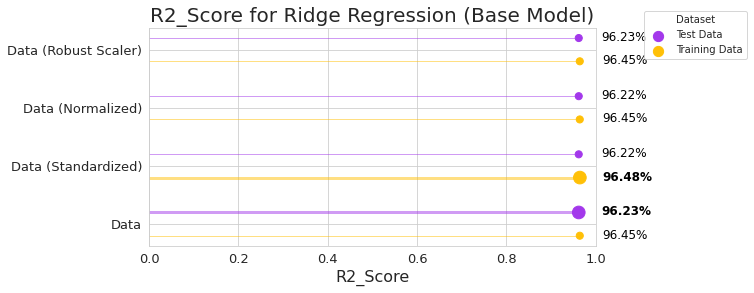

In [ ]:
PlotMetric(eval_train = ridreg_eval_train, eval_test = ridreg_eval_test, metric = "R2_Score", idx = new_idx, top_result = 1,
           model_title = "Ridge Regression (Base Model)", figsize = [8, 4], legend_coor =(1.35, 1.1), float_limit = 2)

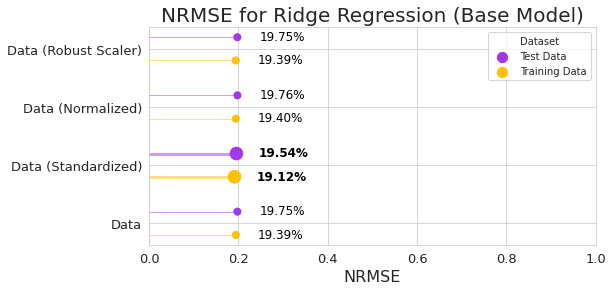

In [ ]:

PlotMetric(eval_train = ridreg_eval_train, eval_test = ridreg_eval_test, metric = "NRMSE", idx = new_idx, top_result = 1,
          model_title = "Ridge Regression (Base Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 2)

#### 3.2.2.2 Ridge Regression: Hyperparameter Tuning

In [ ]:
# # Hyperparameter tuning (alpha values)
# params      = {"alpha": (np.logspace(-8, 8, 100))} # It will check from 1e-8 to 1e+8
# ridge       = Ridge()
# cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
# ridge_model = GridSearchCV(ridge, params, cv = cv)

# data_to_train = {"Data"                 : [X_train_2, y_train_2],
#                  "Data (Standardized)"  : [data_std_2["X_train"], data_std_2["y_train"]],
#                  "Data (Normalized)"    : [data_norm_2["X_train"], data_norm_2["y_train"]],
#                  "Data (Robust Scaler)" : [data_robs_2["X_train"], data_robs_2["y_train"]]}

# for idx, (data, data_values) in enumerate(data_to_train.items()):
#     ridge_model.fit(data_values[0], data_values[1])
#     print("{} \nBest Param: {}, Best Score Result: {}".format(data, ridge_model.best_params_, ridge_model.best_score_))

Hyperparameter Tuning Result for Ridge Regression
- Data
Best Param: {"alpha": 0.013848863713938746}, Best Score Result: 0.9618791852514523
- Data (Standardized)
Best Param: {"alpha": 1.74752840000769}, Best Score Result: 0.9618900813762504
- Data (Normalized)
Best Param: {"alpha": 0.0200923300256505}, Best Score Result: 0.9618809982443115
- Data (Robust Scaler)
Best Param: {"alpha": 0.0200923300256505}, Best Score Result: 0.9618800507884051

In [ ]:
# Dataset 2 (default/no feature scaling)
RidgeRegDef             = Ridge(alpha = 0.013848863713938746)
RidgeRegDef.fit(X_train_2, y_train_2)
ridreg_pred_tuned       = PredictData(RidgeRegDef, X_train_2, X_test_2)

# Dataset 2 Standardized
RidgeRegStd             = Ridge(alpha = 1.74752840000769)
RidgeRegStd.fit(data_std_2["X_train"], data_std_2["y_train"])
ridreg_std_pred_tuned   = PredictData(RidgeRegStd, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
RidgeRegNorm            = Ridge(alpha = 0.0200923300256505)
RidgeRegNorm.fit(data_norm_2["X_train"], data_norm_2["y_train"])
ridreg_norm_pred_tuned  = PredictData(RidgeRegNorm, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
RidgeRegRobs            = Ridge(alpha = 0.0200923300256505)
RidgeRegRobs.fit(data_robs_2["X_train"], data_robs_2["y_train"])
ridreg_robs_pred_tuned  = PredictData(RidgeRegRobs, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
ridreg_train_tuned = StoreEvaluationResult(y_train_2, ridreg_pred_tuned["y_train"],
                                           data_std_2["y_train"], ridreg_std_pred_tuned["y_train"],
                                           data_norm_2["y_train"], ridreg_norm_pred_tuned["y_train"],
                                           data_robs_2["y_train"], ridreg_robs_pred_tuned["y_train"])
ridreg_test_tuned  = StoreEvaluationResult(y_test_2, ridreg_pred_tuned["y_test"],
                                           data_std_2["y_test"], ridreg_std_pred_tuned["y_test"],
                                           data_norm_2["y_test"], ridreg_norm_pred_tuned["y_test"],
                                           data_robs_2["y_test"], ridreg_robs_pred_tuned["y_test"])

In [ ]:
# Evaluation Result for Training Data
ridreg_eval_train_tuned       = pd.DataFrame.from_dict([ridreg_train_tuned["raw"], ridreg_train_tuned["std"],
                                                        ridreg_train_tuned["norm"], ridreg_train_tuned["robs"]])
ridreg_eval_train_tuned.index = new_idx
print(f'{"RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION":^120s}')
ridreg_eval_train_tuned

                                 RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,67811.275178,1.145992e+10,107051.004903,8.079435e-02,0.191132,0.964768
Data (Standardized),0.118906,3.524647e-02,0.187740,4.689110e-01,0.191229,0.964754
Data (Normalized),0.019066,9.059961e-04,0.030100,2.590762e+10,0.191156,0.964765
Data (Robust Scaler),0.077542,1.498563e-02,0.122416,1.290612e+00,0.191155,0.964765


In [ ]:
# Evaluation Result for Testing Data
ridreg_eval_test_tuned       = pd.DataFrame.from_dict([ridreg_test_tuned["raw"], ridreg_test_tuned["std"],
                                                   ridreg_test_tuned["norm"], ridreg_test_tuned["robs"]])
ridreg_eval_test_tuned.index = new_idx
print(f'{"RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION":^120s}')
ridreg_eval_test_tuned

                                 RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,72110.967863,1.237301e+10,111234.028633,0.086190,0.195342,0.962191
Data (Standardized),0.126511,3.806665e-02,0.195107,0.608266,0.195477,0.962164
Data (Normalized),0.020278,9.782880e-04,0.031278,0.195349,0.195378,0.962183
Data (Robust Scaler),0.082472,1.618103e-02,0.127205,0.608156,0.195374,0.962184


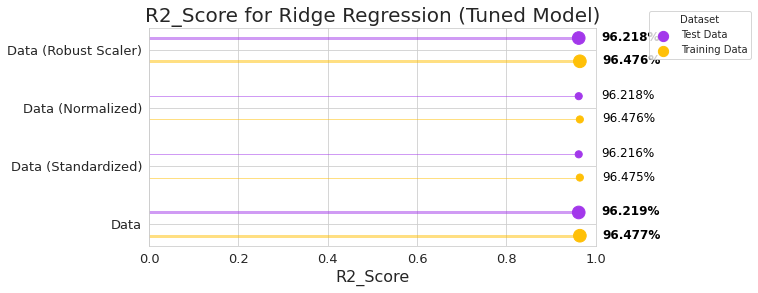

In [ ]:
PlotMetric(eval_train = ridreg_eval_train_tuned, eval_test = ridreg_eval_test_tuned, metric = "R2_Score", idx = new_idx,
           top_result = 2, model_title = "Ridge Regression (Tuned Model)", figsize = [8, 4], legend_coor = (1.36, 1.1), float_limit = 3)

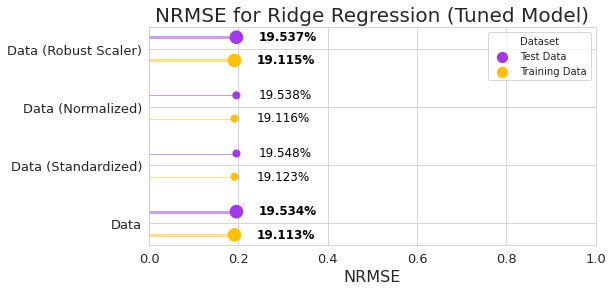

In [ ]:
PlotMetric(eval_train = ridreg_eval_train_tuned, eval_test = ridreg_eval_test_tuned, metric = "NRMSE", idx = new_idx, top_result = 2,
           model_title = "Ridge Regression (Tuned Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 3)

### 3.2.3 Lasso Regression

#### 3.2.3.1 Lasso Regression: Base Model

In [ ]:
LassoReg         = Lasso()

# Dataset 2
LassoReg.fit(X_train_2, y_train_2)
lasreg_pred      = PredictData(LassoReg, X_train_2, X_test_2)

# Dataset 2 Standardized
LassoReg.fit(data_std_2["X_train"], data_std_2["y_train"])
lasreg_std_pred  = PredictData(LassoReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
LassoReg.fit(data_norm_2["X_train"], data_norm_2["y_train"])
lasreg_norm_pred = PredictData(LassoReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
LassoReg.fit(data_robs_2["X_train"], data_robs_2["y_train"])
lasreg_robs_pred = PredictData(LassoReg, data_robs_2["X_train"], data_robs_2["X_test"])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+13, tolerance: 1.182e+11



In [ ]:
# Store evaluation result for both training and testing dataset
lasreg_train = StoreEvaluationResult(y_train_2, lasreg_pred["y_train"],
                                     data_std_2["y_train"], lasreg_std_pred["y_train"],
                                     data_norm_2["y_train"], lasreg_norm_pred["y_train"],
                                     data_robs_2["y_train"], lasreg_robs_pred["y_train"])

lasreg_test  = StoreEvaluationResult(y_test_2, lasreg_pred["y_test"],
                                     data_std_2["y_test"], lasreg_std_pred["y_test"],
                                     data_norm_2["y_test"], lasreg_norm_pred["y_test"],
                                     data_robs_2["y_test"], lasreg_robs_pred["y_test"])

In [ ]:
# Evaluation for Training Data
lasreg_eval_train       = pd.DataFrame.from_dict([lasreg_train["raw"], lasreg_train["std"], lasreg_train["norm"], lasreg_train["robs"]])
lasreg_eval_train.index = new_idx
print(f'{"LASSO REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
lasreg_eval_train

                                 LASSO REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,67846.979382,1.146483e+10,107073.953141,8.081474e-02,1.911563e-01,0.964753
Data (Standardized),0.834135,1.000000e+00,1.000000,1.000000e+00,2.028241e+31,0.000000
Data (Normalized),0.133755,2.571269e-02,0.160352,2.939779e+11,2.888641e+15,0.000000
Data (Robust Scaler),0.543984,4.253039e-01,0.652153,4.582276e+00,2.349630e+16,0.000000


In [ ]:
# Evaluation for Data Testing
lasreg_eval_test       = pd.DataFrame.from_dict([lasreg_test["raw"], lasreg_test["std"], lasreg_test["norm"], lasreg_test["robs"]])
lasreg_eval_test.index = new_idx
print(f'{"LASSO REGRESSION (BASE MODEL) - TEST DATA EVALUATION":^120s}')
lasreg_eval_test

                                  LASSO REGRESSION (BASE MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,72199.207337,1.238588e+10,111291.874920,0.086361,1.954298e-01,0.962152
Data (Standardized),0.839744,1.006154e+00,1.003072,1.000000,4.068945e+31,-0.000065
Data (Normalized),0.134654,2.587092e-02,0.160844,1.868536,2.897515e+15,-0.000065
Data (Robust Scaler),0.547642,4.279213e-01,0.654157,1.900083,4.713697e+16,-0.000065


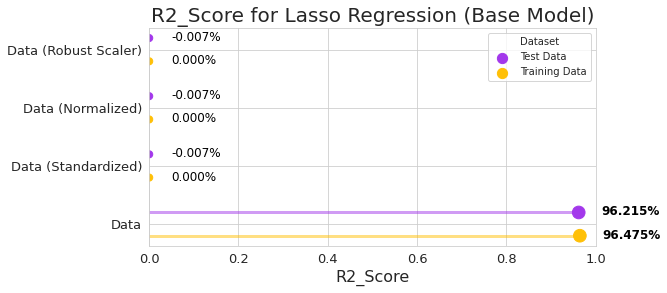

In [ ]:
PlotMetric(eval_train = lasreg_eval_train, eval_test = lasreg_eval_test, metric = "R2_Score", idx = new_idx, top_result = 1,
           model_title = "Lasso Regression (Base Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 3)

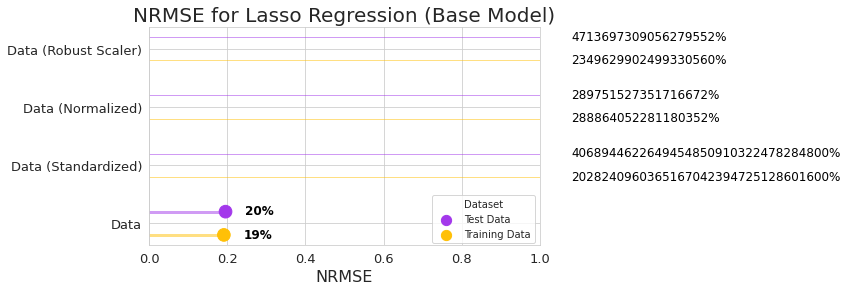

In [ ]:
PlotMetric(eval_train = lasreg_eval_train, eval_test = lasreg_eval_test, metric = "NRMSE", idx =  new_idx, top_result = 1,
          model_title = "Lasso Regression (Base Model)", figsize = [7, 4], legend_coor =(1, 0.25), float_limit = 0)

#### 3.2.3.2 Lasso Regression: Hyperparameter Tuning

In [ ]:
# params      = {"alpha": (np.logspace(-10, 10, 100))} # It will check from 1e-10 to 1e+10
# lasso       = Lasso(tol = 0.05) # tolerance for stopping criteria, default is 1e-4, set it higher so model can converge
# cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
# lasso_model = GridSearchCV(lasso, params, cv = cv)

# data_to_train = {"Data"                 : [X_train_2, y_train_2],
#                  "Data (Standardized)"  : [data_std_2["X_train"], data_std_2["y_train"]],
#                  "Data (Normalized)"    : [data_norm_2["X_train"], data_norm_2["y_train"]],
#                  "Data (Robust Scaler)" : [data_robs_2["X_train"], data_robs_2["y_train"]]}

# for idx, (data, data_values) in enumerate(data_to_train.items()):
#     lasso_model.fit(data_values[0], data_values[1])
#     print("{} \nBest Param: {}, Best Score Result: {}".format(data, lasso_model.best_params_, lasso_model.best_score_))

Hyperparameter Tuning Result
- Data
Best Param: {"alpha": 533.6699231206302}, Best Score Result: 0.9553662473042566
- Data (Standardized)
Best Param: {"alpha": 1e-10}, Best Score Result: 0.9522732729417466
- Data (Normalized)
Best Param: {"alpha": 0.0001830738280295366}, Best Score Result: 0.9459517056655325
- Data (Robust Scaler)
Best Param: {"alpha": 0.0007390722033525775}, Best Score Result: 0.9484703356860236

In [ ]:
# Dataset 2
LassoRegDef             = Lasso(alpha = 533.6699231206302, tol = 0.05)
LassoRegDef.fit(X_train_2, y_train_2)
lasreg_pred_tuned       = PredictData(LassoRegDef, X_train_2, X_test_2)

# Dataset 2 Standardized
LassoRegStd             = Lasso(alpha = 1e-10, tol = 0.05)
LassoRegStd.fit(data_std_2["X_train"], data_std_2["y_train"])
lasreg_std_pred_tuned   = PredictData(LassoRegStd, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
LassoRegNorm            = Lasso(alpha =  0.0001830738280295366, tol = 0.05)
LassoRegNorm.fit(data_norm_2["X_train"], data_norm_2["y_train"])
lasreg_norm_pred_tuned  = PredictData(LassoRegNorm, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
LassoRegRobs            = Lasso(alpha = 0.0007390722033525775, tol = 0.05)
LassoRegRobs.fit(data_robs_2["X_train"], data_robs_2["y_train"])
lasreg_robs_pred_tuned  = PredictData(LassoRegRobs, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
lasreg_train_tuned  = StoreEvaluationResult(y_train_2, lasreg_pred_tuned["y_train"],
                                            data_std_2["y_train"], lasreg_std_pred_tuned["y_train"],
                                            data_norm_2["y_train"], lasreg_norm_pred_tuned["y_train"],
                                            data_robs_2["y_train"], lasreg_robs_pred_tuned["y_train"])

lasreg_test_tuned   = StoreEvaluationResult(y_test_2, lasreg_pred_tuned["y_test"],
                                            data_std_2["y_test"], lasreg_std_pred_tuned["y_test"],
                                            data_norm_2["y_test"], lasreg_norm_pred_tuned["y_test"],
                                            data_robs_2["y_test"], lasreg_robs_pred_tuned["y_test"])

In [ ]:
# Evaluation for Training Data
lasreg_eval_train_tuned       = pd.DataFrame.from_dict([lasreg_train_tuned["raw"], lasreg_train_tuned["std"],
                                                        lasreg_train_tuned["norm"], lasreg_train_tuned["robs"]])
lasreg_eval_train_tuned.index = new_idx
print(f'{"LASSO REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION":^120s}')
lasreg_eval_train_tuned

                                 LASSO REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,71003.948114,1.280459e+10,113157.383870,8.136981e-02,0.210019,0.960634
Data (Standardized),0.122045,3.608693e-02,0.189966,5.089983e-01,0.193412,0.963913
Data (Normalized),0.020659,1.063726e-03,0.032615,5.453036e+10,0.217111,0.958630
Data (Robust Scaler),0.084520,1.765191e-02,0.132861,1.537576e+00,0.217358,0.958496


In [ ]:
# Evaluation for Testing  Data
lasreg_eval_test_tuned       = pd.DataFrame.from_dict([lasreg_test_tuned["raw"], lasreg_test_tuned["std"],
                                                       lasreg_test_tuned["norm"], lasreg_test_tuned["robs"]])
lasreg_eval_test_tuned.index = new_idx
print(f'{"LASSO REGRESSION (TUNED MODEL) - TEST DATA EVALUATION":^120s}')
lasreg_eval_test_tuned

                                 LASSO REGRESSION (TUNED MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,73266.815935,1.317556e+10,114784.841911,0.083668,0.209629,0.959738
Data (Standardized),0.129113,3.890872e-02,0.197253,0.612425,0.197718,0.961327
Data (Normalized),0.021112,1.073896e-03,0.032770,0.176392,0.214667,0.958488
Data (Robust Scaler),0.086198,1.779694e-02,0.133405,0.542163,0.214786,0.958408


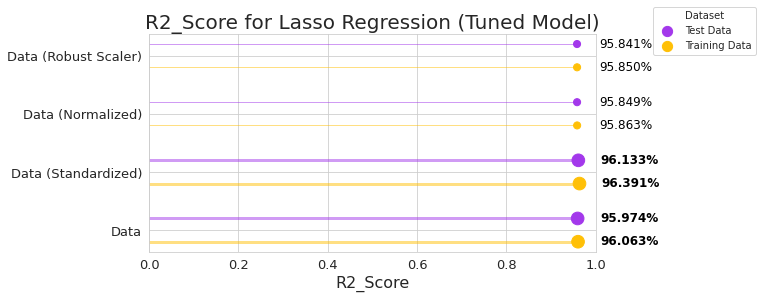

In [ ]:
PlotMetric(eval_train = lasreg_eval_train_tuned, eval_test =  lasreg_eval_test_tuned, metric = "R2_Score", idx = new_idx,
           top_result = 2, model_title = "Lasso Regression (Tuned Model)", figsize = [8, 4], legend_coor =(1.37, 1.15), float_limit = 3)

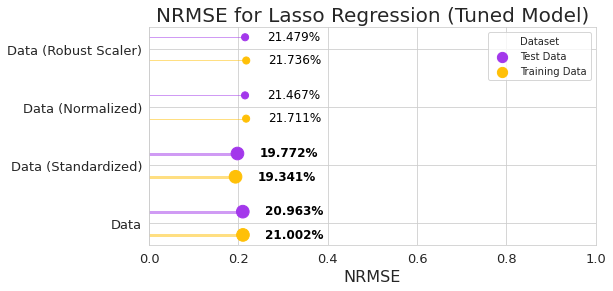

In [ ]:
PlotMetric(eval_train = lasreg_eval_train_tuned, eval_test = lasreg_eval_test_tuned, metric = "NRMSE", idx =  new_idx, top_result = 2,
           model_title = "Lasso Regression (Tuned Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 3)

**Analisis**

Base model dari Lasso memiliki *performance* yang bisa dibilang buruk. Dataset yang kita olah memiliki banyak *categorical predictor* seperti Store, Holiday_Flag, Month, Week, WeekOfYear, Day, dan yang lainnya. Berdasarkan hasil *feature importance* yang didapatkan dari koefisien regresor, pada dataset ini *numerical predictor* justru memiliki nilai *importance* yang sangat rendah dibandingkan *categorical predictor*.

Algoritma Lasso dari ScikitLearn sepertinya tidak bisa menangani masalah ini karena Lasso memberikan nilai *penalty* terhadap fitur yang memiliki kontribusi minor sehingga koefisiennya mendekati/menjadi nol [[1]](http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/153-penalized-regression-essentials-ridge-lasso-elastic-net/#:~:text=In%20the%20case%20of%20lasso,be%20exactly%20equal%20to%20zero.), sedangkan untuk *categorical predictor* yang telah di-encode akan terpecah menjadi beberapa variabel (Contoh: fitur "Store" akan menjadi "Store_1", "Store_2", .... "Store N") dan tidak masuk akal untuk mengambil sebagian variabel saja dari *categorical predictor*. Misalnya, setelah diketahui nilai koefisiennya, "Store_27" dan "Store_31" tidak diberikan penalti karena memiliki kontribusi lebih besar, tetapi "Store _44" memiliki kontribusinya yang sangat kecil sehingga Lasso memberi penalti dengan menjadikan koefisiennya 0, padahal tidak bisa begitu karena mereka merupakan satu kesatuan dan seharusnya seluruh fitur-fitur yang telah di-encode dari fitur "Store" diambil semua atau tidak dipakai semua) sehingga diperlukan *treatment* khusus (modifikasi Lasso) untuk masalah seperti ini. [[2]](https://stats.stackexchange.com/questions/209009/how-to-treat-categorical-predictors-in-lasso) [[3]](https://stats.stackexchange.com/questions/548958/why-are-my-elastic-net-and-lasso-r-squared-measures-negative). Sementara, untuk alasan mengapa Lasso memiliki *performance* yang baik pada dataset tanpa *feature scaling* belum kami temukan karena berdasarkan sumber yang ada Lasso seharusnya memiliki *performance* yang baik jika skala datanya sama [[4]](https://stats.stackexchange.com/questions/86434/is-standardisation-before-lasso-really-necessary).

Sementara setelah dilakukan hyperpameter tuning, dengan alpha yang mendekati 0, *performance* model langsung meningkat karena semakin kecil alpha maka semakin kecil penalti yang diberikan oleh Lasso. Berdasarkan dokumentasi dari Scikit Learn [[5]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), jika nilai alpha di-set mendekati atau sama dengan nol, maka cara kerja Lasso secara esensinya sama saja dengan Linear Regression standard karena efek penalti yang diberikan hampir tidak ada. Oleh karena itu saat tuning dengan alpha mendekati 0, *performance* model baik nilai R2 score dan NRMSE-nya langsung berubah drastis.

### 3.2.4 ElasticNet Regression

#### 3.2.4.1 ElasticNet Regression: Base Model

In [ ]:
ENetReg = ElasticNet()

# Dataset 2
ENetReg.fit(X_train_2, y_train_2)
enetreg_pred      = PredictData(ENetReg, X_train_2, X_test_2)

# Dataset 2 Standardized
ENetReg.fit(data_std_2["X_train"], data_std_2["y_train"])
enetreg_std_pred  = PredictData(ENetReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
ENetReg.fit(data_norm_2["X_train"], data_norm_2["y_train"])
enetreg_norm_pred = PredictData(ENetReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
ENetReg.fit(data_robs_2["X_train"], data_robs_2["y_train"])
enetreg_robs_pred = PredictData(ENetReg, data_robs_2["X_train"], data_robs_2["X_test"])


In [ ]:
# Store evaluation result for both training and testing dataset
enetreg_train = StoreEvaluationResult(y_train_2, enetreg_pred["y_train"],
                                      data_std_2["y_train"], enetreg_std_pred["y_train"],
                                      data_norm_2["y_train"], enetreg_norm_pred["y_train"],
                                      data_robs_2["y_train"], enetreg_robs_pred["y_train"])

enetreg_test  = StoreEvaluationResult(y_test_2, enetreg_pred["y_test"],
                                      data_std_2["y_test"], enetreg_std_pred["y_test"],
                                      data_norm_2["y_test"], enetreg_norm_pred["y_test"],
                                      data_robs_2["y_test"], enetreg_robs_pred["y_test"])

In [ ]:
# Evaluation for Training Data
enetreg_eval_train       = pd.DataFrame.from_dict([enetreg_train["raw"], enetreg_train["std"], enetreg_train["norm"], enetreg_train["robs"]])
enetreg_eval_train.index = new_idx
print(f'{"ELASTICNET REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
enetreg_eval_train

                               ELASTICNET REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                               


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,449623.806429,2.887409e+11,537346.135025,6.222937e-01,6.532266e+00,0.1123
Data (Standardized),0.834135,1.000000e+00,1.000000,1.000000e+00,2.028241e+31,0.0000
Data (Normalized),0.133755,2.571269e-02,0.160352,2.939779e+11,2.888641e+15,0.0000
Data (Robust Scaler),0.543984,4.253039e-01,0.652153,4.582276e+00,2.349630e+16,0.0000


In [ ]:
# Evaluation for Data Testing
enetreg_eval_test       = pd.DataFrame.from_dict([enetreg_test["raw"], enetreg_test["std"], enetreg_test["norm"], enetreg_test["robs"]])
enetreg_eval_test.index = new_idx
print(f'{"ELASTICNET REGRESSION (BASE MODEL)- TEST DATA EVALUATION":^120s}')
enetreg_eval_test

                                ELASTICNET REGRESSION (BASE MODEL)- TEST DATA EVALUATION                                


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,453752.080094,2.918417e+11,540223.752675,0.646947,6.605507e+00,0.108197
Data (Standardized),0.839744,1.006154e+00,1.003072,1.000000,4.068945e+31,-0.000065
Data (Normalized),0.134654,2.587092e-02,0.160844,1.868536,2.897515e+15,-0.000065
Data (Robust Scaler),0.547642,4.279213e-01,0.654157,1.900083,4.713697e+16,-0.000065


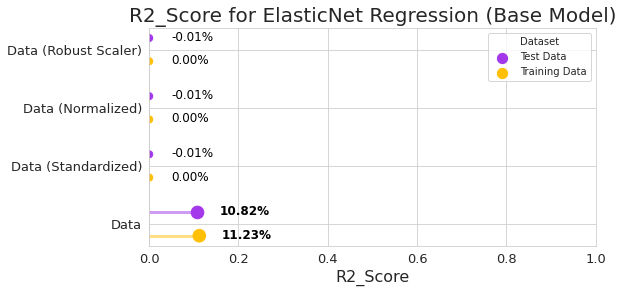

In [ ]:
PlotMetric(eval_train = enetreg_eval_train, eval_test = enetreg_eval_test,  metric ="R2_Score", idx = new_idx, top_result = 1,
           model_title = "ElasticNet Regression (Base Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 2)

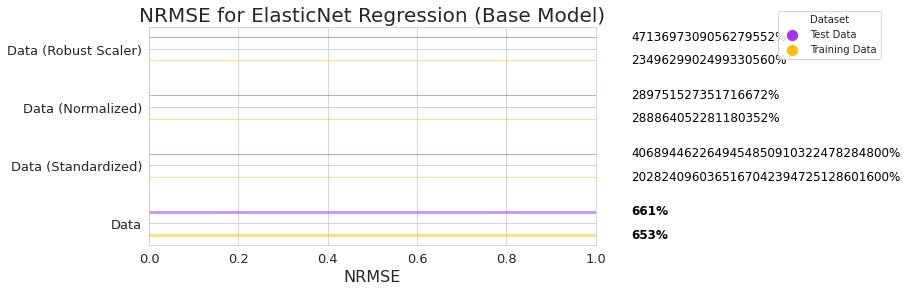

In [ ]:
PlotMetric(eval_train = enetreg_eval_train, eval_test = enetreg_eval_test, metric = "NRMSE", idx = new_idx, top_result = 1,
           model_title = "ElasticNet Regression (Base Model)", figsize = [8, 4], legend_coor =(1.65, 1.1), float_limit = 0)

Hasil dari model ElasticNet sangat buruk, baik dari nilai R2 Score maupun nilai NRMSE-nya. Menurut asumsi kami, hal ini disebabkan karena ElasticNet merupakan kombinasi antara Ridge dan Lasso. Sementara seperti yang dapat kita lihat pada tahap sebelumnya, performance Lasso pada data ini juga bisa dibilang buruk dan hanya membaik ketika alpha-nya di-set mendekati nol (yang berarti sama saja dengan menggunakan Linear Regression standard). Detail penjelasan mengenai Lasso ada di tahap sebelumnya.

### 3.2.4 Random Forest Regressor

In [ ]:
RFR = RandomForestRegressor()

# Dataset 2
RFR.fit(X_train_2, y_train_2)
rfr_pred      = PredictData(RFR, X_train_2, X_test_2)

# Dataset 2 Standardized
RFR.fit(data_std_2["X_train"], data_std_2["y_train"].ravel())
rfr_std_pred  = PredictData(RFR, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
RFR.fit(data_norm_2["X_train"], data_norm_2["y_train"].ravel())
rfr_norm_pred = PredictData(RFR, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
RFR.fit(data_robs_2["X_train"], data_robs_2["y_train"].ravel())
rfr_robs_pred = PredictData(RFR, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
rfr_train = StoreEvaluationResult(y_train_2, rfr_pred["y_train"],
                                data_std_2["y_train"], rfr_std_pred["y_train"],
                                data_norm_2["y_train"], rfr_norm_pred["y_train"],
                                data_robs_2["y_train"], rfr_robs_pred["y_train"])

rfr_test  = StoreEvaluationResult(y_test_2, rfr_pred["y_test"],
                                data_std_2["y_test"], rfr_std_pred["y_test"],
                                data_norm_2["y_test"], rfr_norm_pred["y_test"],
                                data_robs_2["y_test"], rfr_robs_pred["y_test"])

In [ ]:
# Evaluation for Training Data
rfr_eval_train       = pd.DataFrame.from_dict([rfr_train["raw"], rfr_train["std"], rfr_train["norm"], rfr_train["robs"]])
rfr_eval_train.index = new_idx
print(f'{"ELASTICNET REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
rfr_eval_train

                               ELASTICNET REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                               


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,22294.512238,1.802947e+09,42461.117830,1.976217e-02,0.075843,0.994457
Data (Standardized),0.038617,5.405547e-03,0.073522,1.512456e-01,0.074852,0.994594
Data (Normalized),0.006251,1.425501e-04,0.011939,2.563758e+09,0.075866,0.994456
Data (Robust Scaler),0.025356,2.201135e-03,0.046916,3.837979e-01,0.073219,0.994825


In [ ]:
# Evaluation for Data Testing
rfr_eval_test       = pd.DataFrame.from_dict([rfr_test["raw"], rfr_test["std"], rfr_test["norm"], rfr_test["robs"]])
rfr_eval_test.index = new_idx
print(f'{"ELASTICNET REGRESSION (BASE MODEL)- TEST DATA EVALUATION":^120s}')
rfr_eval_test

                                ELASTICNET REGRESSION (BASE MODEL)- TEST DATA EVALUATION                                


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,59799.296979,1.267710e+10,112592.624730,0.053505,0.202676,0.961262
Data (Standardized),0.105383,3.913969e-02,0.197838,0.528563,0.202794,0.961097
Data (Normalized),0.016962,1.004411e-03,0.031692,0.092192,0.202674,0.961174
Data (Robust Scaler),0.068455,1.663684e-02,0.128984,0.459789,0.202913,0.961119


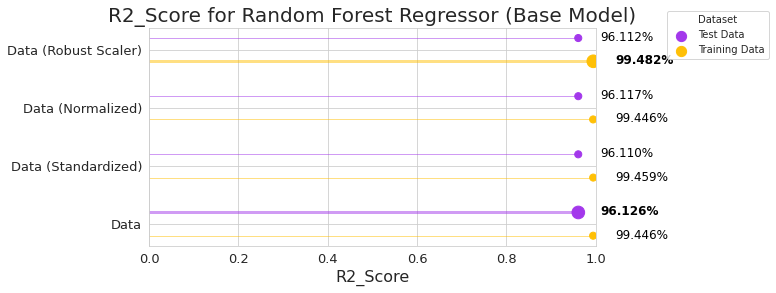

In [ ]:
PlotMetric(eval_train = rfr_eval_train, eval_test = rfr_eval_test, metric = "R2_Score", idx = new_idx, top_result = 1,
           model_title = "Random Forest Regressor (Base Model)", figsize = [8, 4], legend_coor =(1.4, 1.1), float_limit = 3)

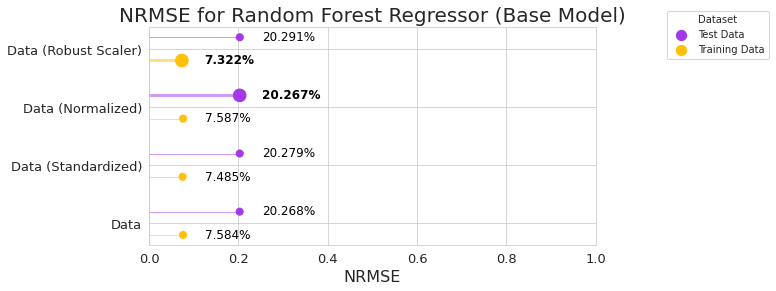

In [ ]:
PlotMetric(eval_train = rfr_eval_train, eval_test = rfr_eval_test, metric = "NRMSE", idx = new_idx, top_result = 1,
           model_title = "Random Forest Regressor (Base Model)", figsize = [8, 4], legend_coor =(1.4, 1.1), float_limit = 3)

In [ ]:
# # Define the Estimator and the Parameter Ranges
# RFR = RandomForestRegressor()
# max_leaf_nodes = [2, 3, 4, 5, 6, 7]
# min_samples_split =  [2, 5, 10, 15, 100]
# max_depth = [5, 10,15,20]
# max_features = [3,4,5]
# n_estimators = [50, 100, 200]

# # Define the param distribution dictionary
# param_distributions = dict(max_leaf_nodes=max_leaf_nodes,
#                            min_samples_split=min_samples_split,
#                            max_depth=max_depth,
#                            max_features=max_features,
#                            n_estimators=n_estimators)

# # Build the gridsearch
# cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
# RFR_model   = GridSearchCV(RFR, param_distributions, cv = cv)
# grid_results = RFR_model.fit(X_train, y_train)

# # Summarize the results in a readable format
# print("Best params: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
# results_df = pd.DataFrame(grid_results.cv_results_)

Best params: [0.03310504 0.03252657 0.03242932 ... 0.2445071  0.24843373 0.24777039], using {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 7, 'min_samples_split': 100, 'n_estimators': 50}

In [ ]:
# Define the Estimator and the Parameter Ranges
RFR = RandomForestRegressor()
max_leaf_nodes = [2, 3, 4, 5, 6, 7]
min_samples_split =  [2, 5, 10, 15, 100]
max_depth = [5, 10, 15, 20]
max_features = [3, 4, 5]
n_estimators = [50, 100, 200]

# Define the param distribution dictionary
param_distributions = dict(max_leaf_nodes=max_leaf_nodes,
                           min_samples_split=min_samples_split,
                           max_depth=max_depth,
                           max_features=max_features,
                           n_estimators=n_estimators)
# Build the gridsearch
cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
RFR_model   = GridSearchCV(RFR, param_distributions, cv = cv, scoring = 'r2')

data_to_train = {"Data"                 : [X_train_2, y_train_2.ravel()],
                 "Data (Standardized)"  : [data_std_2["X_train"], data_std_2["y_train"].ravel()],
                 "Data (Normalized)"    : [data_norm_2["X_train"], data_norm_2["y_train"].ravel()],
                 "Data (Robust Scaler)" : [data_robs_2["X_train"], data_robs_2["y_train"].ravel()]}

for idx, (data, data_values) in enumerate(data_to_train.items()):
    RFR_model.fit(data_values[0], data_values[1])
    print("{} \nBest Param: {}, Best Score Result: {}".format(data, RFR_model.best_params_, RFR_model.best_score_))

In [ ]:
# cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
# ridge_model = GridSearchCV(ridge, params, cv = cv)
